In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate 
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2
from tqdm import tqdm
import datetime

from IPython.display import HTML
from base64 import b64encode

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

train_images_path = "../input/kittiroadsegmentation/training/image_2/"

train_ground_truth_path = "../input/kittiroadsegmentation/training/gt_image_2/"

test_images_path = "../input/kittiroadsegmentation/testing/"


In [3]:
# Calculating the sizes of training, validation, and testing sets

# Total number of images in the training images directory
total_images = len(os.listdir(train_images_path))

# Assigning 80% of the total images to the training set
train_set_size = int(total_images * 0.8)
print(f"Number of Training Examples: {train_set_size}")

# Assigning 10% of the total images to the validation set
validation_set_size = int(total_images * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

# The remaining images will be used for the test set
test_set_size = total_images - train_set_size - validation_set_size
print(f"Number of Testing Examples: {test_set_size}")


Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [4]:
# Initialize Constants
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
SEED = 123

In [5]:
# Function to load an image and its corresponding mask as a dictionary
def load_image_and_mask(image_path: str) -> dict:
    # Reading and decoding the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=N_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.uint8)

    # Adjusting the path to point to the corresponding mask
    # Mask paths have different naming conventions
    mask_path = tf.strings.regex_replace(image_path, "image_2", "gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path, "um_", "um_road_")
    mask_path = tf.strings.regex_replace(mask_path, "umm_", "umm_road_")
    mask_path = tf.strings.regex_replace(mask_path, "uu_", "uu_road_")
    
    # Reading and processing the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=N_CHANNELS)
    
    # Defining the label colors
    non_road_color = np.array([255, 0, 0])
    road_color = np.array([255, 0, 255])
    other_road_color = np.array([0, 0, 0])
    
    # Creating a binary mask for road segmentation
    binary_mask = tf.experimental.numpy.all(mask == road_color, axis=2)
    binary_mask = tf.cast(binary_mask, tf.uint8)
    binary_mask = tf.expand_dims(binary_mask, axis=-1)

    # Returning the image and its corresponding binary mask
    return {'image': img, 'segmentation_mask': binary_mask}


In [6]:
# Generating datasets for training, validation, and testing

# Creating a TensorFlow dataset with all images in the training directory
complete_dataset = tf.data.Dataset.list_files(train_images_path + "*.png", seed=SEED)
complete_dataset = complete_dataset.map(load_image_and_mask)  # Using the modified function for loading images

# Splitting the dataset into training and validation sets
# First, taking the combined size of training and validation datasets
train_and_val_dataset = complete_dataset.take(train_set_size + validation_set_size)

# Separating the validation dataset
validation_dataset = train_and_val_dataset.skip(train_set_size)

# Isolating the training dataset
training_dataset = train_and_val_dataset.take(train_set_size)

# Creating the test dataset by skipping over the training and validation data
testing_dataset = complete_dataset.skip(train_set_size + validation_set_size)


In [7]:
# TensorFlow function to scale image pixel values to the range [0, 1]
@tf.function
def scale_image(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Normalizing the image
    return input_image, input_mask

# TensorFlow function to preprocess images for training
# Includes resizing and random flipping
@tf.function
def preprocess_for_training(data: dict) -> tuple:
    # Resizing the image and mask to the specified IMG_SIZE
    resized_image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    resized_mask = tf.image.resize(data['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # Randomly flipping the image and mask horizontally
    if tf.random.uniform(()) > 0.5:
        resized_image = tf.image.flip_left_right(resized_image)
        resized_mask = tf.image.flip_left_right(resized_mask)

    # Scaling the image
    resized_image, resized_mask = scale_image(resized_image, resized_mask)

    return resized_image, resized_mask

# TensorFlow function to preprocess images for testing/validation
@tf.function
def preprocess_for_testing(data: dict) -> tuple:
    # Resizing the image and mask to the specified IMG_SIZE
    resized_image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    resized_mask = tf.image.resize(data['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # Scaling the image
    resized_image, resized_mask = scale_image(resized_image, resized_mask)

    return resized_image, resized_mask


In [8]:
# Constants for dataset preparation
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Organizing the datasets into a dictionary for easier access
datasets = {"train": training_dataset, "val": validation_dataset, "test": testing_dataset}

# Preparing the Training Dataset
# Applying the preprocessing function, shuffling, batching, and prefetching
datasets['train'] = datasets['train'].map(preprocess_for_training, num_parallel_calls=tf.data.AUTOTUNE)
datasets['train'] = datasets['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
datasets['train'] = datasets['train'].repeat()
datasets['train'] = datasets['train'].batch(BATCH_SIZE)
datasets['train'] = datasets['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

# Preparing the Validation Dataset
# Applying the preprocessing function, batching, and prefetching
datasets['val'] = datasets['val'].map(preprocess_for_testing)
datasets['val'] = datasets['val'].repeat()
datasets['val'] = datasets['val'].batch(BATCH_SIZE)
datasets['val'] = datasets['val'].prefetch(buffer_size=tf.data.AUTOTUNE)

# Preparing the Testing Dataset
# Applying the preprocessing function, batching, and prefetching
datasets['test'] = datasets['test'].map(preprocess_for_testing)
datasets['test'] = datasets['test'].batch(BATCH_SIZE)
datasets['test'] = datasets['test'].prefetch(buffer_size=tf.data.AUTOTUNE)

# Printing the prepared datasets
print(datasets['train'])
print(datasets['val'])
print(datasets['test'])


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


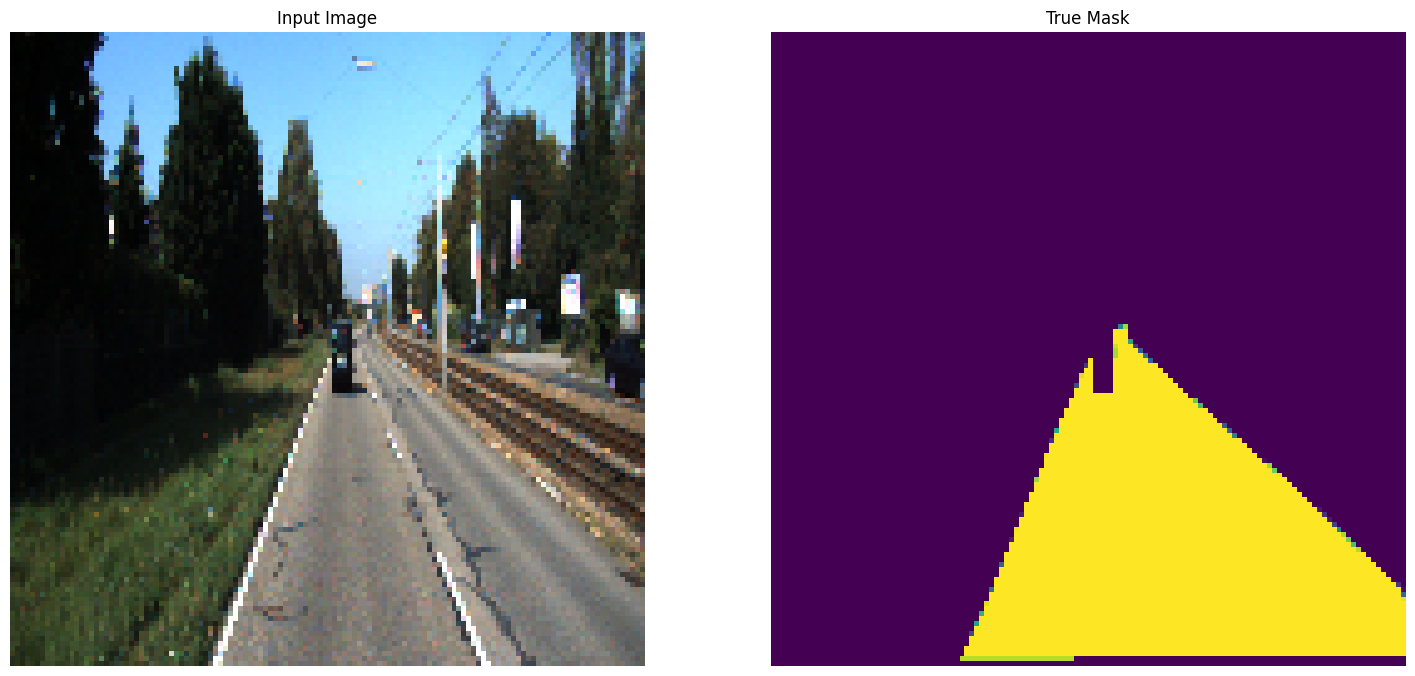

In [10]:
# Function to display a sample of images and masks
def show_image_samples(sample_list):
    # Setting up the plot
    plt.figure(figsize=(18, 18))

    # Titles for each subplot
    titles = ['Input Image', 'True Mask', 'Predicted Mask']

    # Looping through the sample list and plotting each item
    for index in range(len(sample_list)):
        plt.subplot(1, len(sample_list), index + 1)
        plt.title(titles[index])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(sample_list[index]))
        plt.axis('off')
        
    plt.show()
    
# Displaying a sample from the training dataset
for img, mask in datasets["train"].take(3):
    sample_img, sample_mask = img, mask

show_image_samples([sample_img[0], sample_mask[0]])


In [11]:
# Get VGG-16 network as backbone
vgg16_model = VGG16()
vgg16_model.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [12]:
# Setting the input shape for the model
# This defines the dimensions of the input images
model_input_shape = (IMG_SIZE, IMG_SIZE, N_CHANNELS)


In [13]:
# Constructing a new model using the VGG-16 architecture

# Defining the input layer with the specified input shape
model_inputs = Input(model_input_shape)

# Incorporating the VGG-16 network, excluding the top layer, pre-trained on ImageNet
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=model_inputs)

# Selecting layers from VGG-16 to act as feature extractors (encoder)
encoder_block1 = vgg16_base.get_layer("block3_pool").output
encoder_block2 = vgg16_base.get_layer("block4_pool").output
encoder_block3 = vgg16_base.get_layer("block5_pool").output

# Building the decoder to upsample and construct the segmentation map
decoder_step1 = UpSampling2D((2, 2), interpolation='bilinear')(encoder_block3)
decoder_merge1 = Concatenate()([decoder_step1, encoder_block2])

decoder_step2 = UpSampling2D((2, 2), interpolation='bilinear')(decoder_merge1)
decoder_merge2 = Concatenate()([decoder_step2, encoder_block1])

# Final upsampling and output layer
final_upsample = UpSampling2D((8, 8), interpolation='bilinear')(decoder_merge2)
model_outputs = Conv2D(N_CLASSES, 1, activation='sigmoid')(final_upsample)

# Creating the model instance
model = Model(model_inputs, model_outputs, name="VGG_FCN8")


58889256/58889256 [==============================] - 0s 0us/step


In [14]:
# Setting up the metric for Mean Intersection over Union (IoU)
iou_metric = tf.keras.metrics.MeanIoU(num_classes=2)

# Compiling the model with the Adam optimizer, binary cross-entropy loss, and IoU metric
model.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=[iou_metric])


1/1 [==============================] - 6s 6s/step


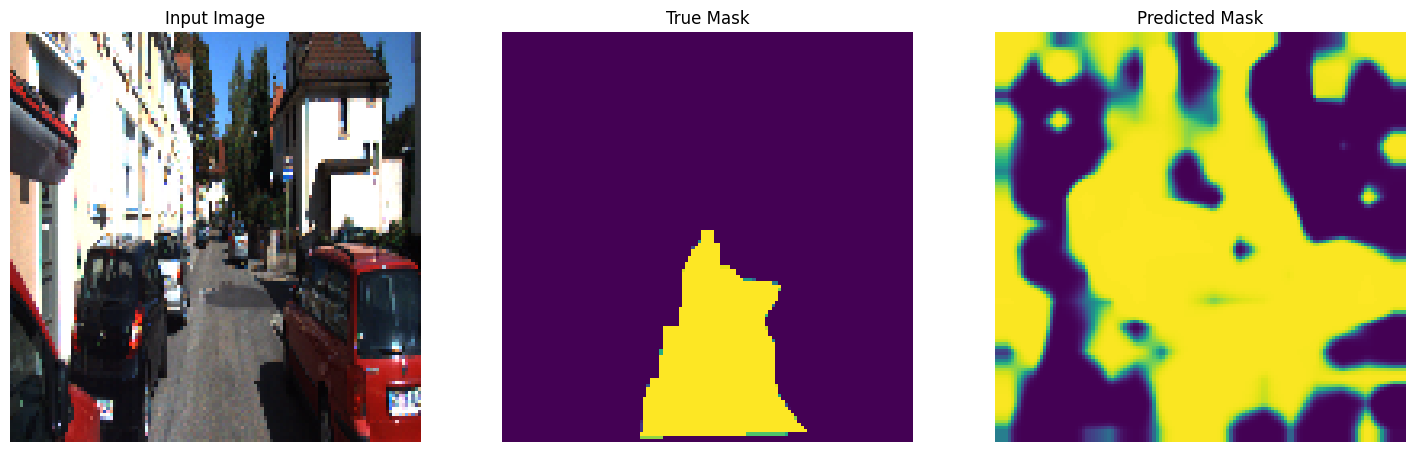

In [15]:
# Function to convert the predicted mask to a binary format
def convert_to_binary_mask(predicted_mask: tf.Tensor) -> tf.Tensor:
    # Rounding the predictions to 0 or 1
    binary_mask = tf.math.round(predicted_mask)
    
    # Expanding dimensions to fit the mask format
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    return binary_mask

# Function to display model predictions
def display_model_predictions(input_dataset=None, number_of_examples=1):
    if input_dataset:
        # Display predictions for the specified number of examples from the dataset
        for img, true_mask in input_dataset.take(number_of_examples):
            predicted_mask = model.predict(img)
            show_image_samples([img[0], true_mask, convert_to_binary_mask(predicted_mask)])
    else:
        # Display the prediction for a single example image
        single_prediction = model.predict(sample_image)
        show_image_samples([sample_image[0], sample_mask[0], single_prediction[0]])

# Retrieving a sample from the training dataset
for img, mask in datasets['train'].take(1):
    sample_image, sample_mask = img, mask

# Showing model predictions
display_model_predictions()


In [16]:
# Custom Callback for displaying predictions at the end of each epoch
class PredictionDisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        display_model_predictions()
        print(f'\nSample Prediction after epoch {epoch + 1}\n')

# Directory for TensorBoard logs
log_directory = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Configuring callbacks for training
training_callbacks = [
    PredictionDisplayCallback(),
    callbacks.TensorBoard(log_directory, histogram_freq=-1),
    callbacks.EarlyStopping(patience=10, verbose=1),
    callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)
]

# Training parameters
EPOCHS = 200
STEPS_PER_EPOCH = train_set_size // BATCH_SIZE
VALIDATION_STEPS = validation_set_size // BATCH_SIZE


1/1 [==============================] - 0s 25ms/step


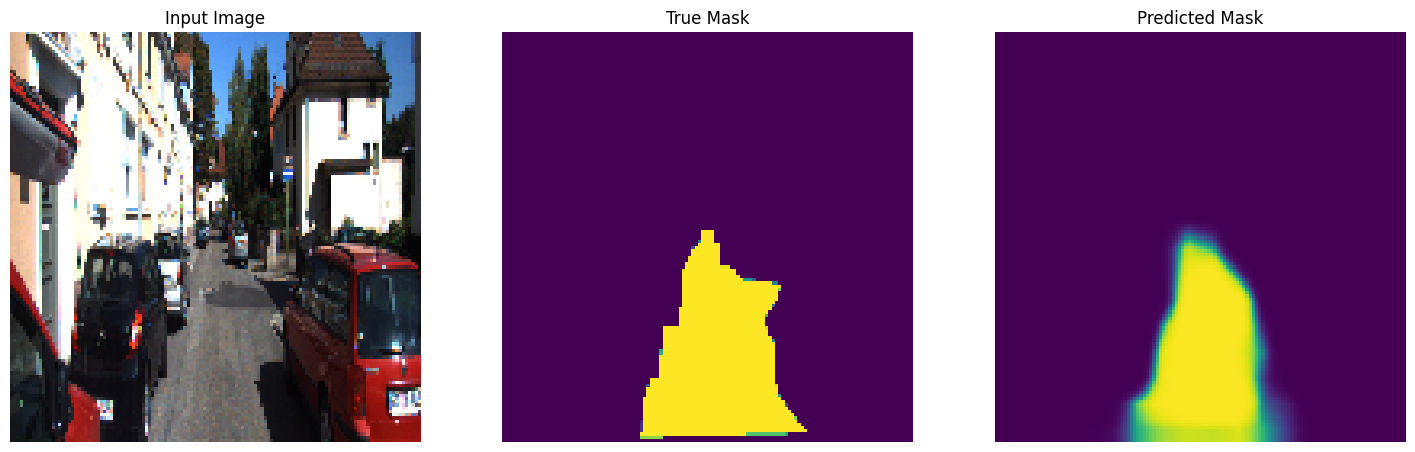


Sample Prediction after epoch 200

7/7 [==============================] - 5s 766ms/step - loss: 0.0386 - mean_io_u: 0.4126


In [17]:
# Training the model
training_history = model.fit(datasets['train'], epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=datasets['val'],
                             validation_steps=VALIDATION_STEPS,
                             callbacks=training_callbacks)


In [18]:
# Function to overlay a mask on an image
def overlay_mask_on_image(image, mask_image, alpha=1., beta=0.5, gamma=0.):
    return cv2.addWeighted(mask_image, alpha, image, beta, gamma)

# Function to process an image and its corresponding mask
def process_image_with_mask(image, mask):
    # Rounding the mask values to the nearest integer
    mask = tf.math.round(mask)
    
    # Creating a mask image with red channel only
    mask_image = np.zeros_like(mask)
    red_mask = np.dstack((mask, mask_image, mask_image))
    red_mask = np.asarray(red_mask, np.float32)
    
    # Converting the input image to a float32 array
    float_image = np.asarray(image, np.float32)
    
    # Overlaying the mask on the image
    final_output_image = overlay_mask_on_image(float_image, red_mask)

    return final_output_image


In [19]:
# Function to save model predictions on a dataset
def store_model_predictions(input_dataset):
    # Index to keep track of each image processed
    image_index = 0
    for batch_img, batch_mask in input_dataset:
        for img, mask in zip(batch_img, batch_mask):
            print(f"Processing image: {image_index}")
            predicted_mask = model.predict(tf.expand_dims(img, axis=0))
            store_image_sample([img, process_image_with_mask(img, predicted_mask[0])], image_index)
            image_index += 1

# Function to save images along with their predictions
def store_image_sample(sample_list, image_index):
    plt.figure(figsize=(18, 18))

    titles = ['Input Image', 'Predicted Mask Overlay']

    for idx in range(len(sample_list)):
        plt.subplot(1, len(sample_list), idx + 1)
        plt.title(titles[idx])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(sample_list[idx]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{image_index}.png")
    plt.show()


Processing image: 0
1/1 [==============================] - 0s 336ms/step


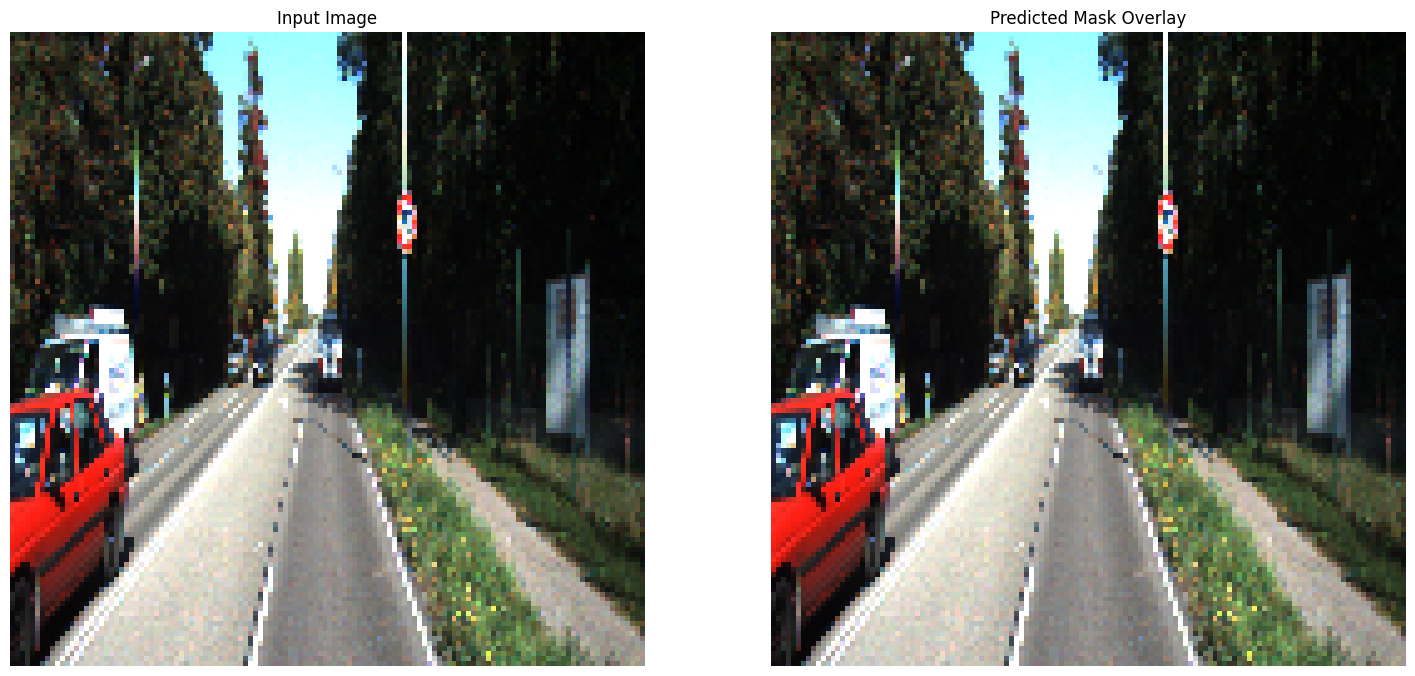

Processing image: 1
1/1 [==============================] - 0s 21ms/step


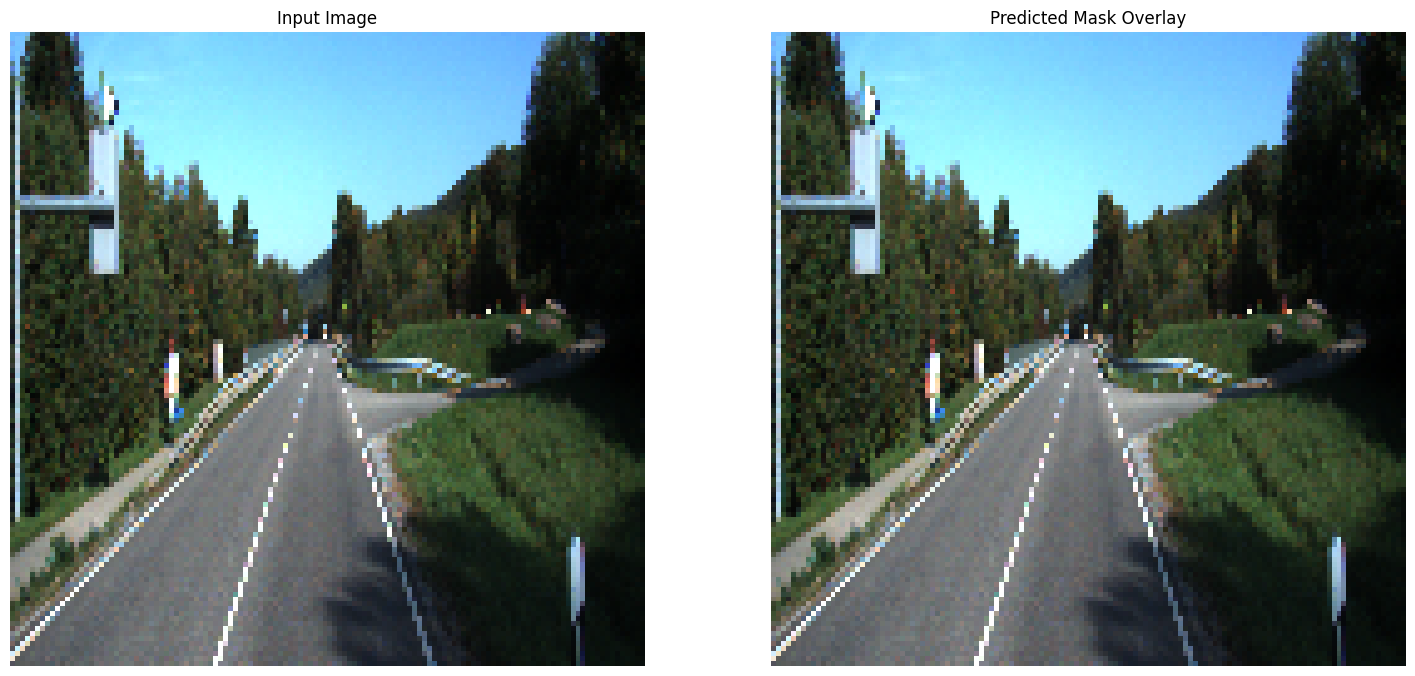

Processing image: 2
1/1 [==============================] - 0s 21ms/step


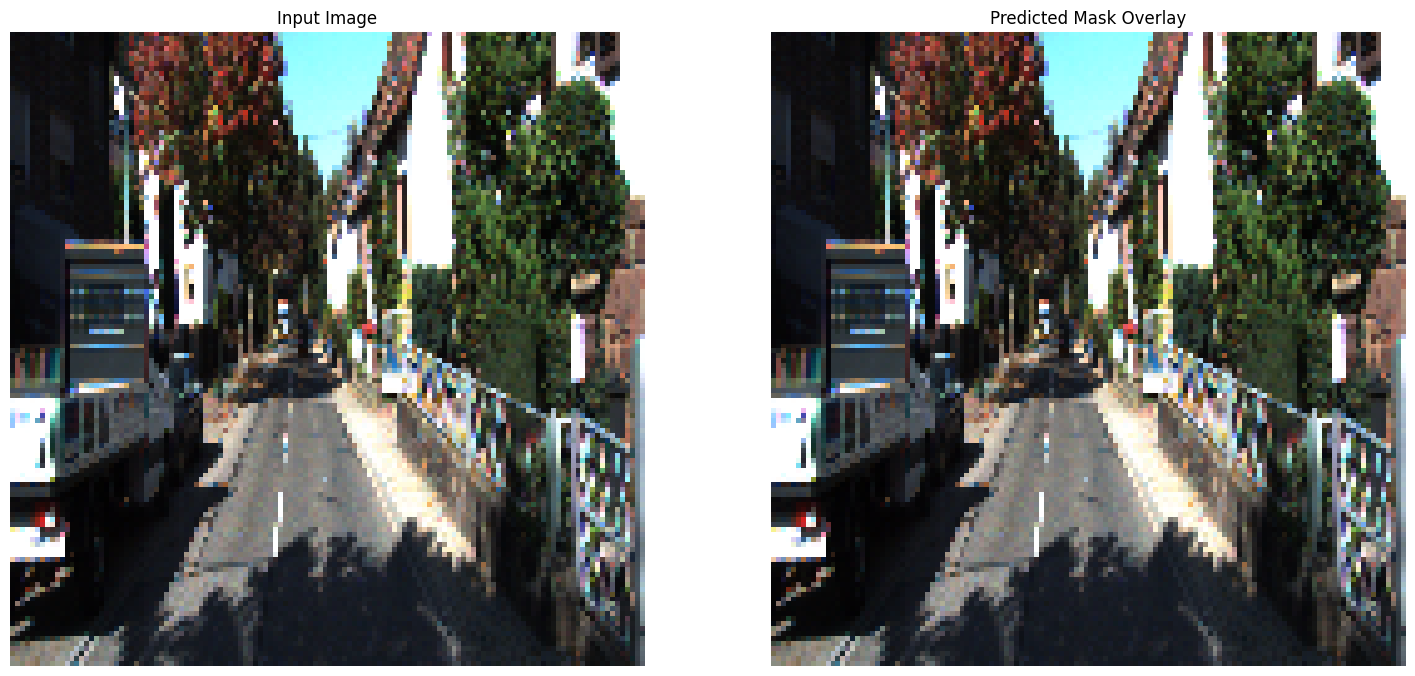

Processing image: 3
1/1 [==============================] - 0s 20ms/step


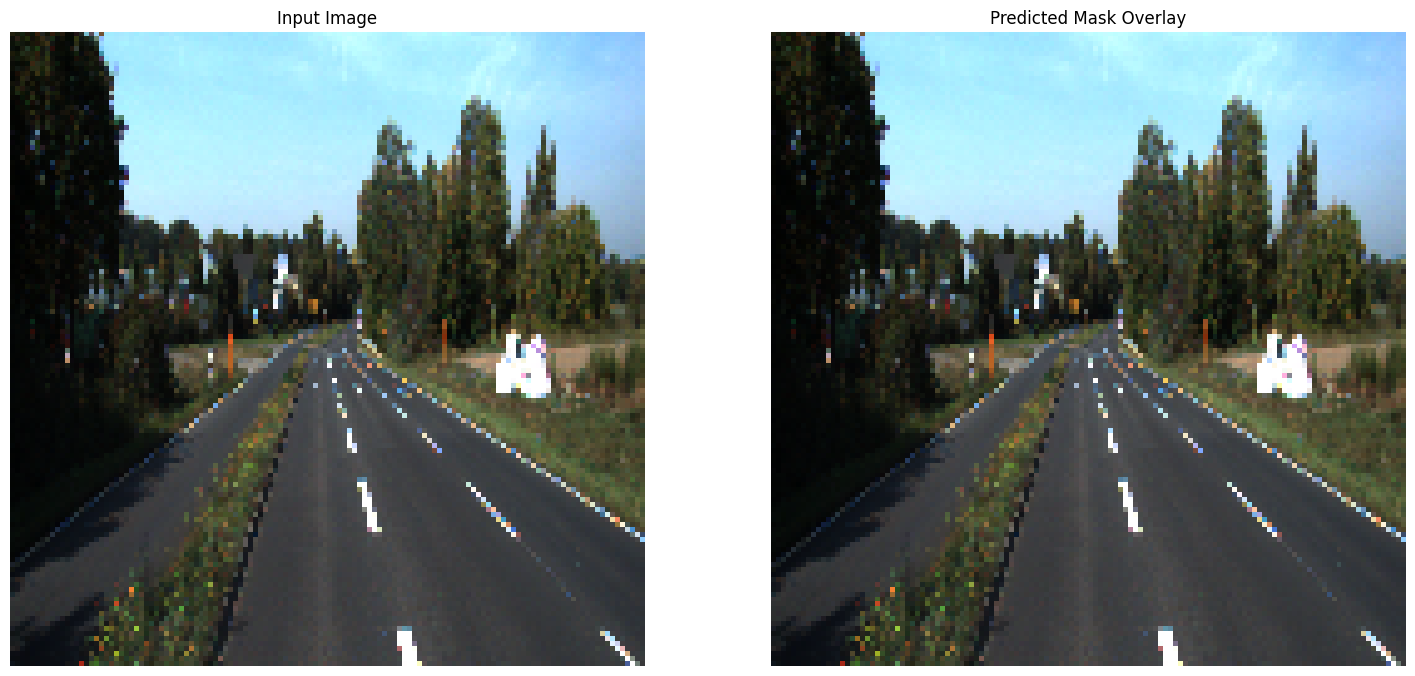

Processing image: 4
1/1 [==============================] - 0s 19ms/step


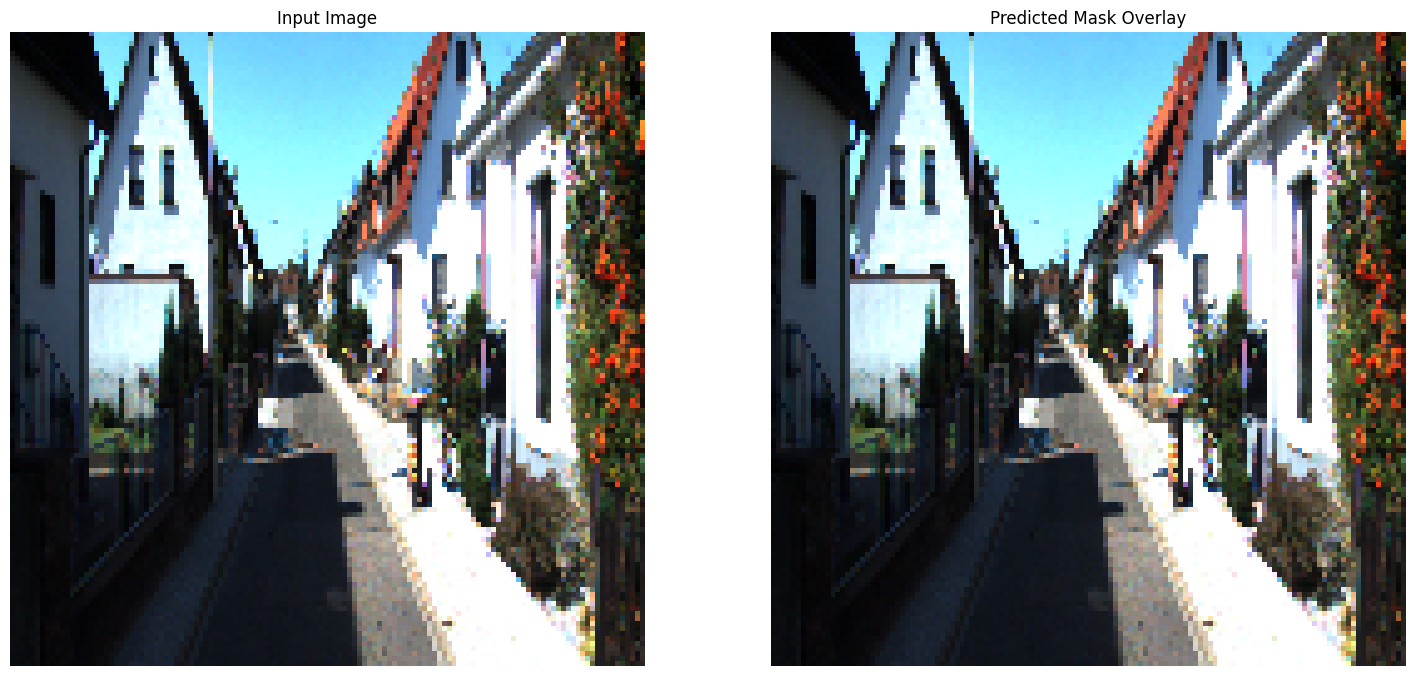

Processing image: 5
1/1 [==============================] - 0s 19ms/step


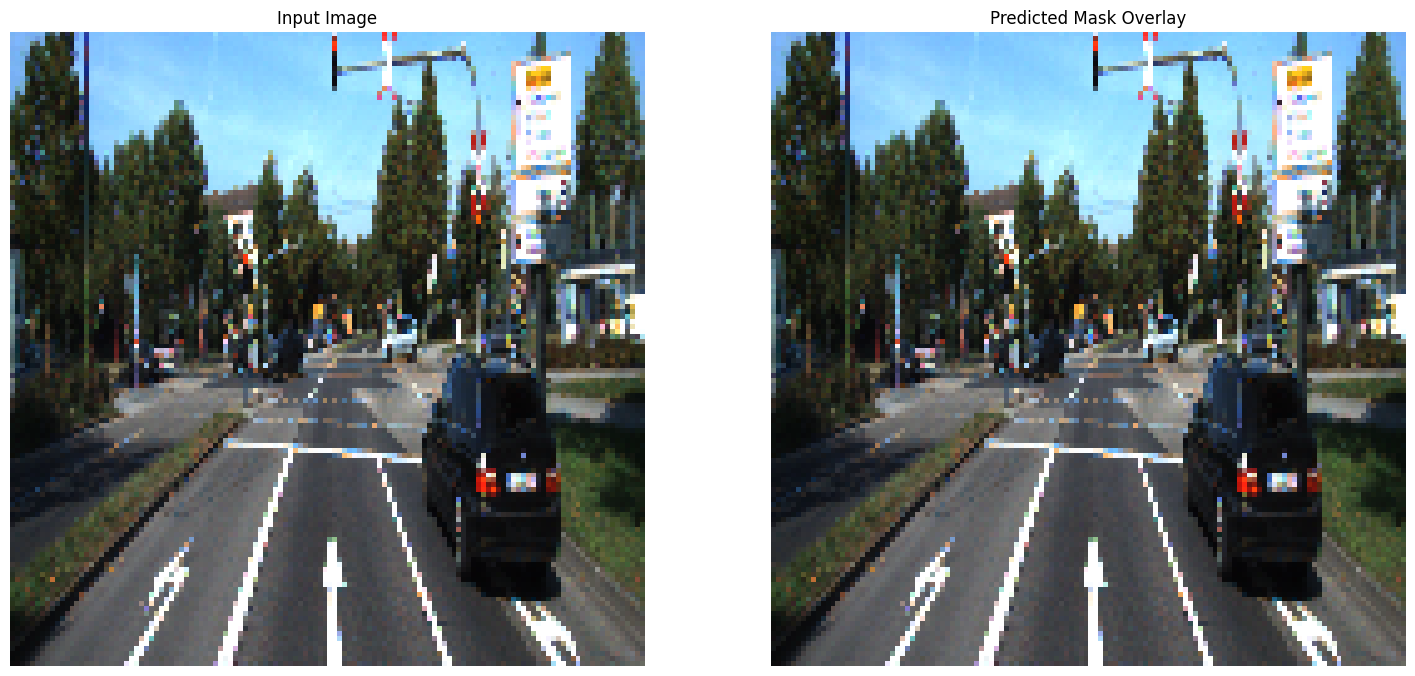

Processing image: 6
1/1 [==============================] - 0s 19ms/step


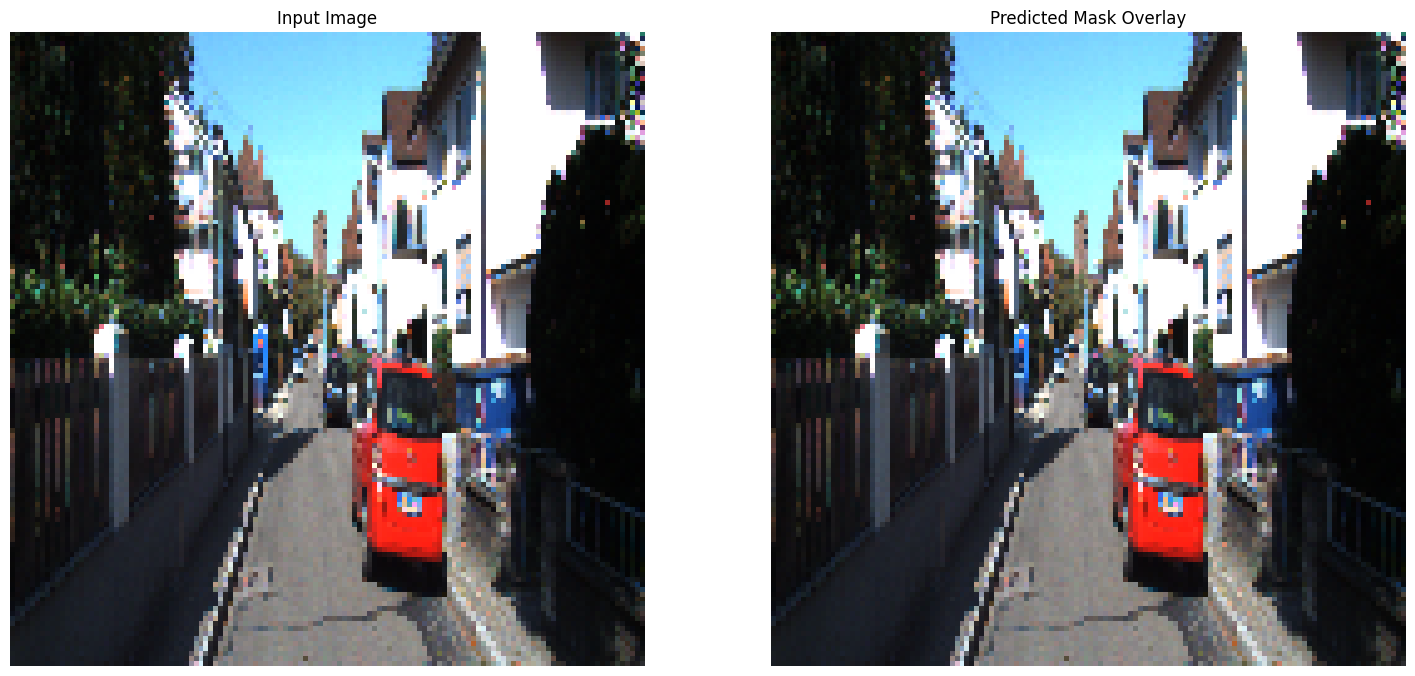

Processing image: 7
1/1 [==============================] - 0s 19ms/step


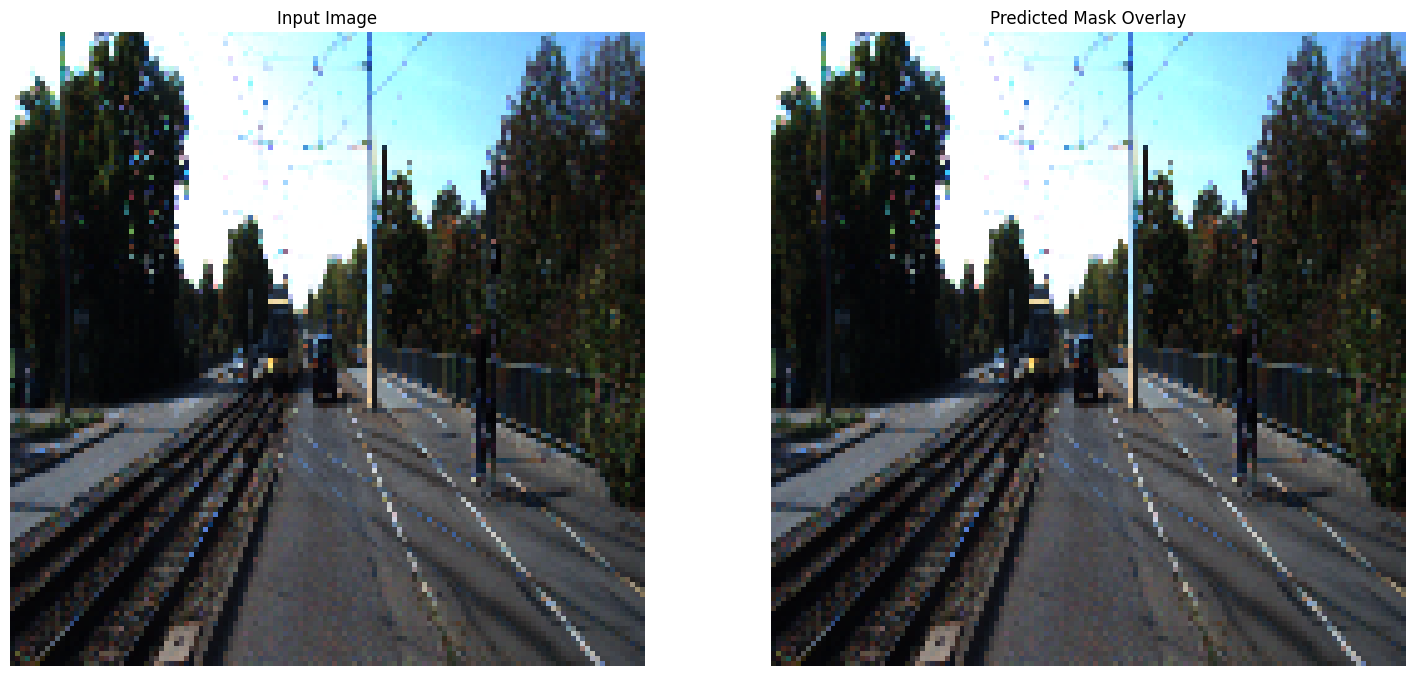

Processing image: 8
1/1 [==============================] - 0s 19ms/step


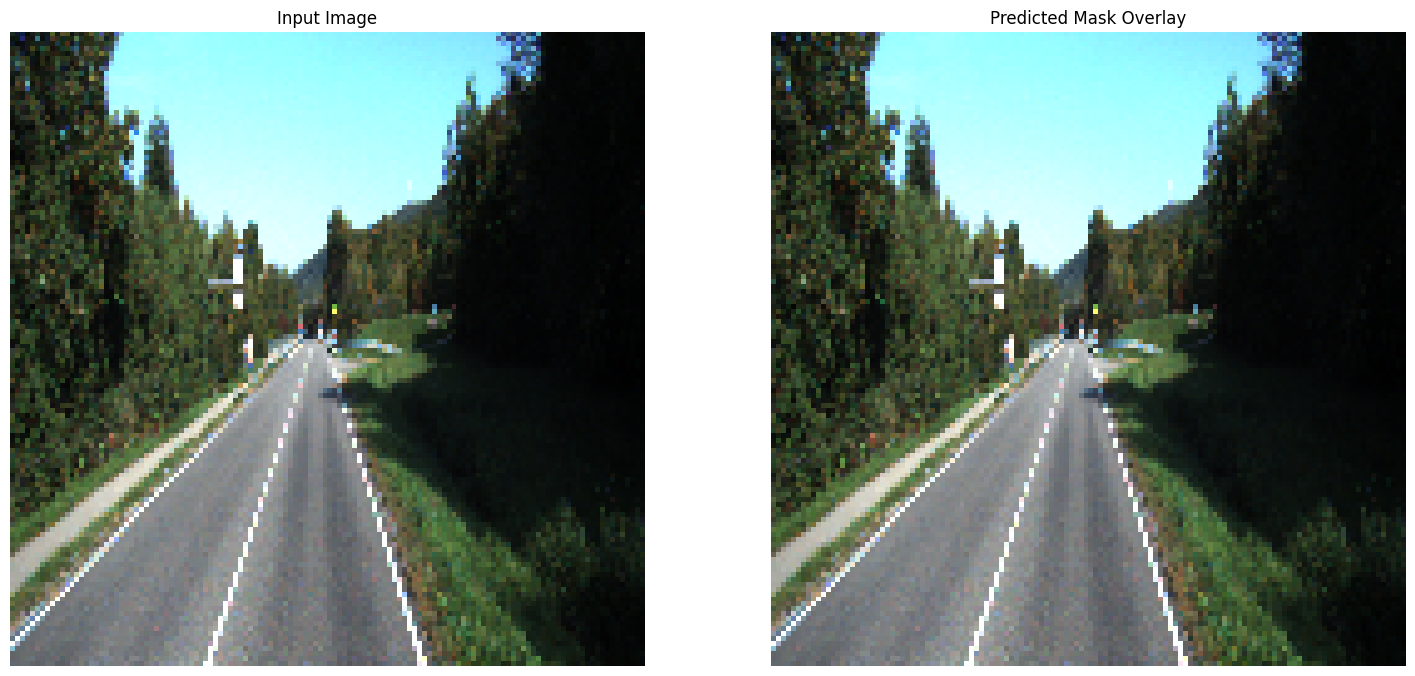

Processing image: 9
1/1 [==============================] - 0s 19ms/step


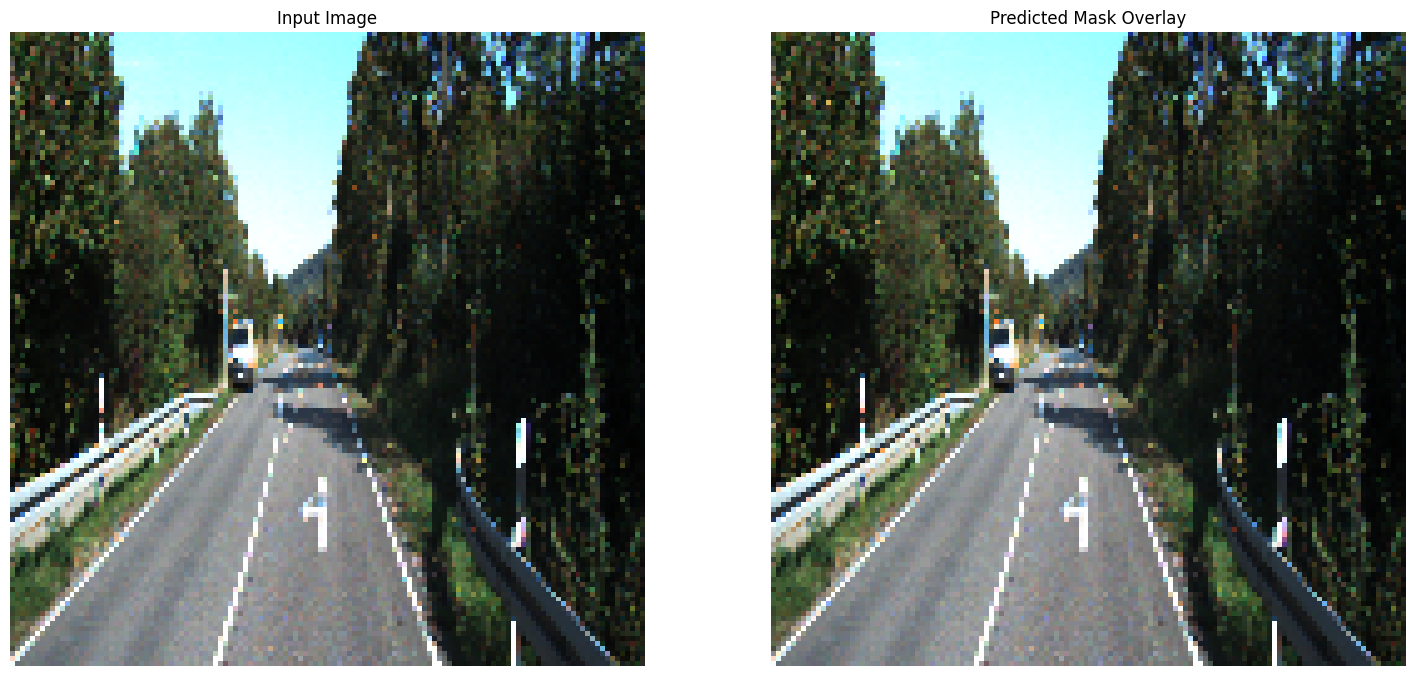

Processing image: 10
1/1 [==============================] - 0s 19ms/step


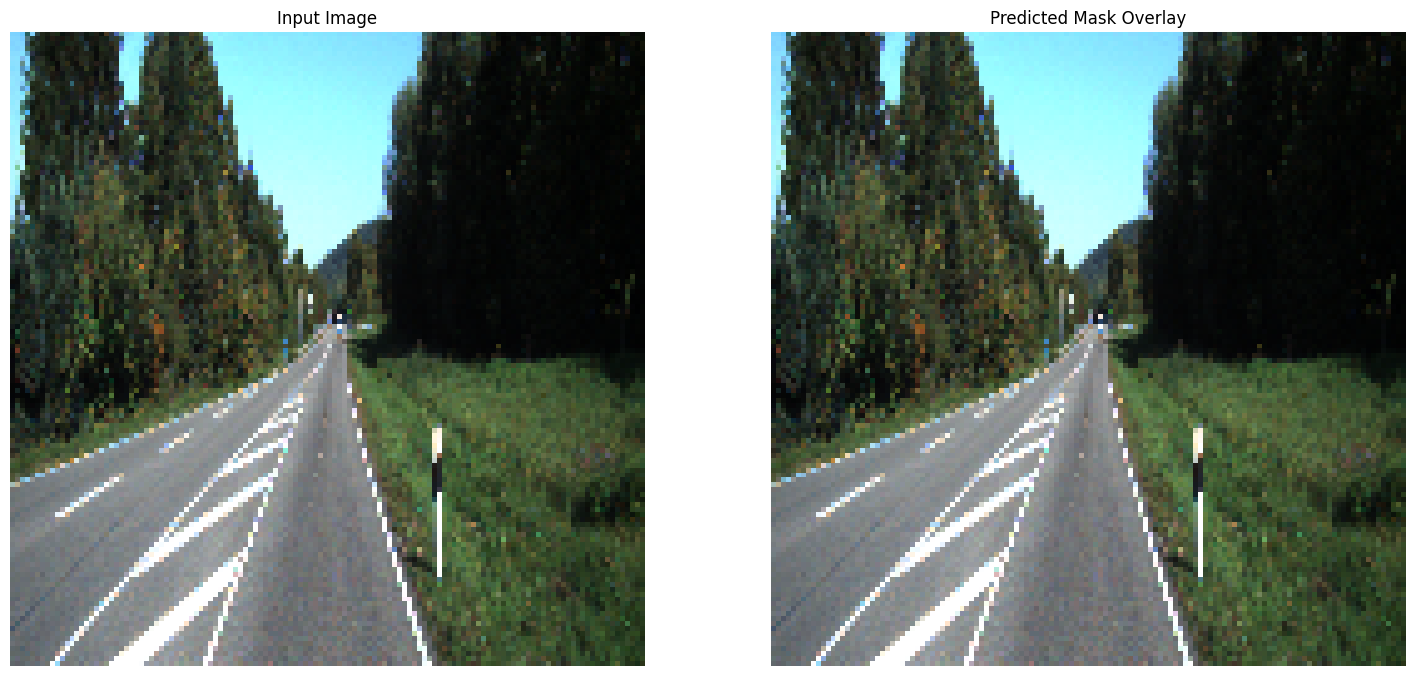

Processing image: 11
1/1 [==============================] - 0s 19ms/step


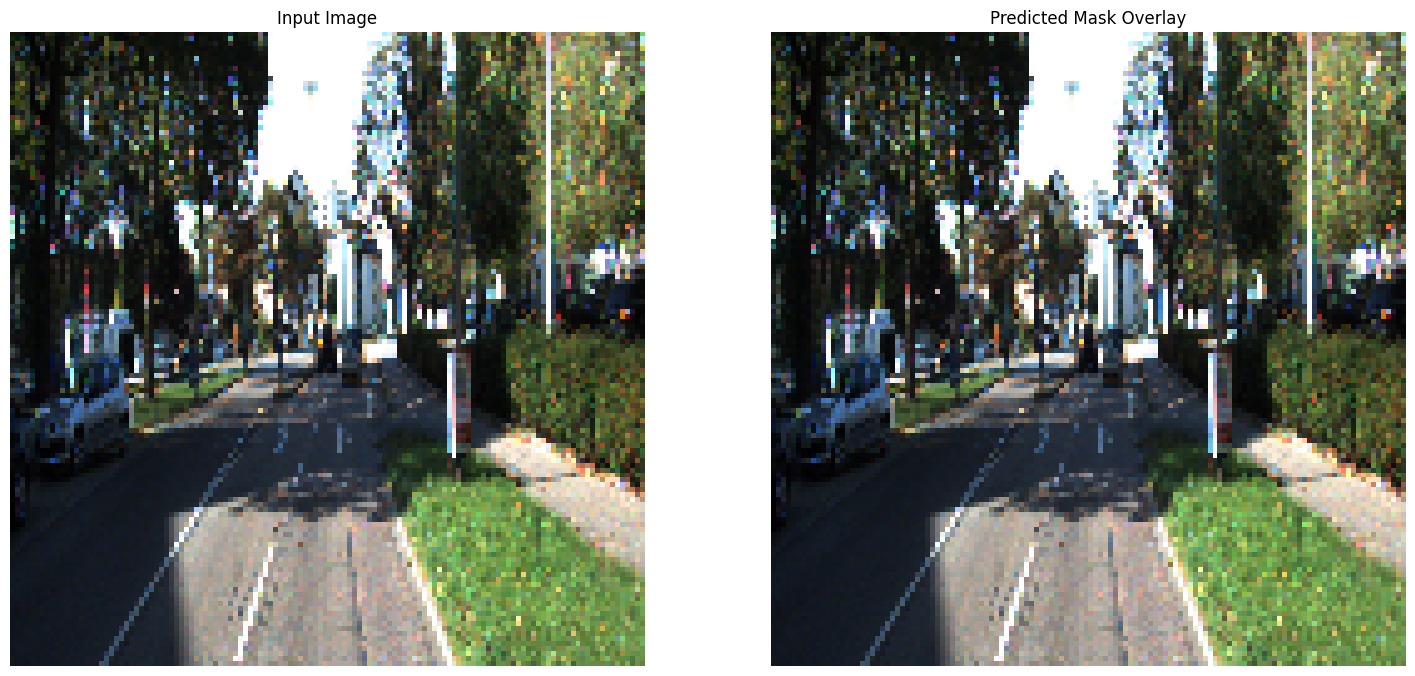

Processing image: 12
1/1 [==============================] - 0s 18ms/step


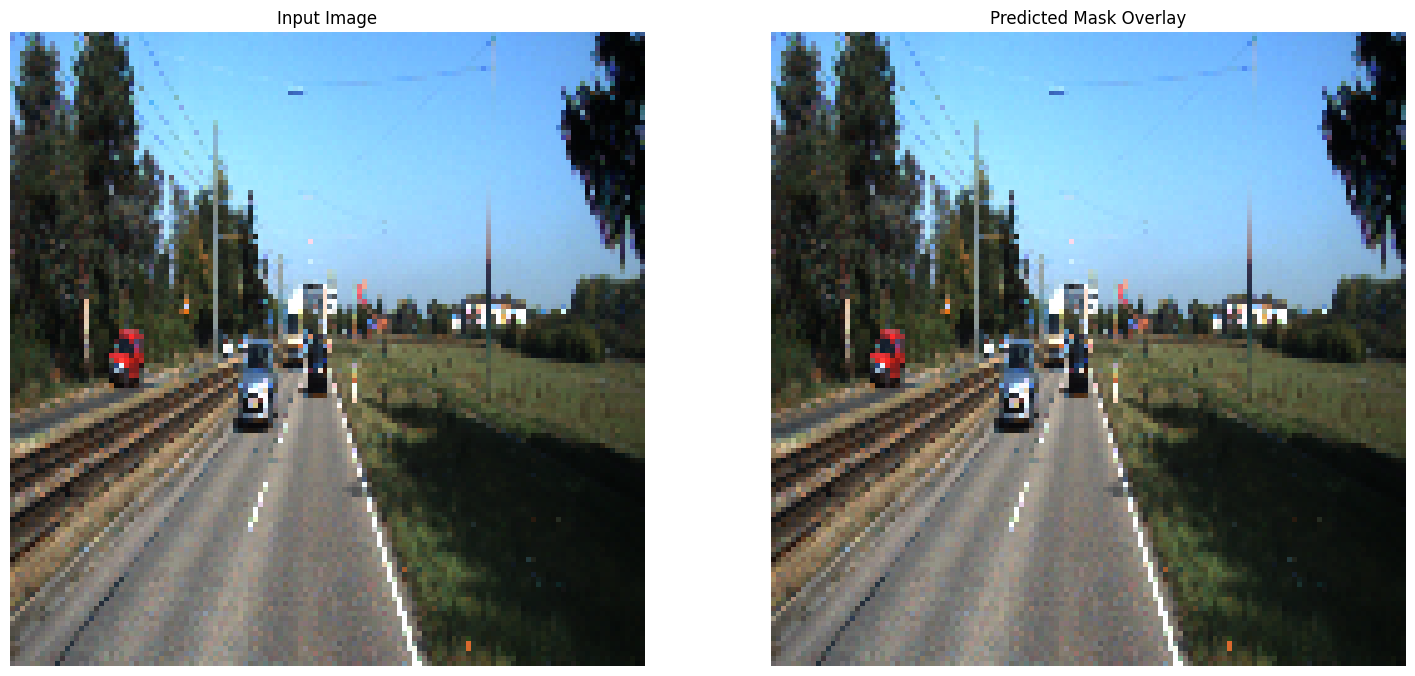

Processing image: 13
1/1 [==============================] - 0s 26ms/step


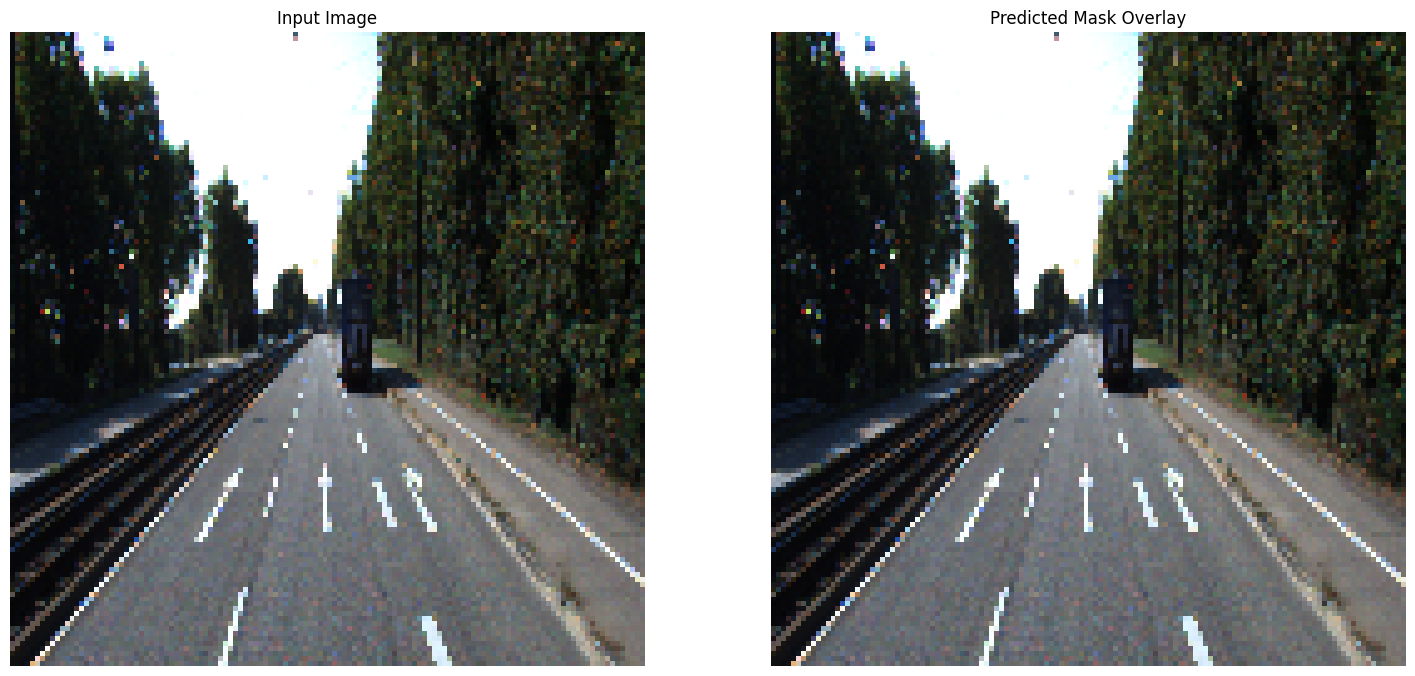

Processing image: 14
1/1 [==============================] - 0s 18ms/step


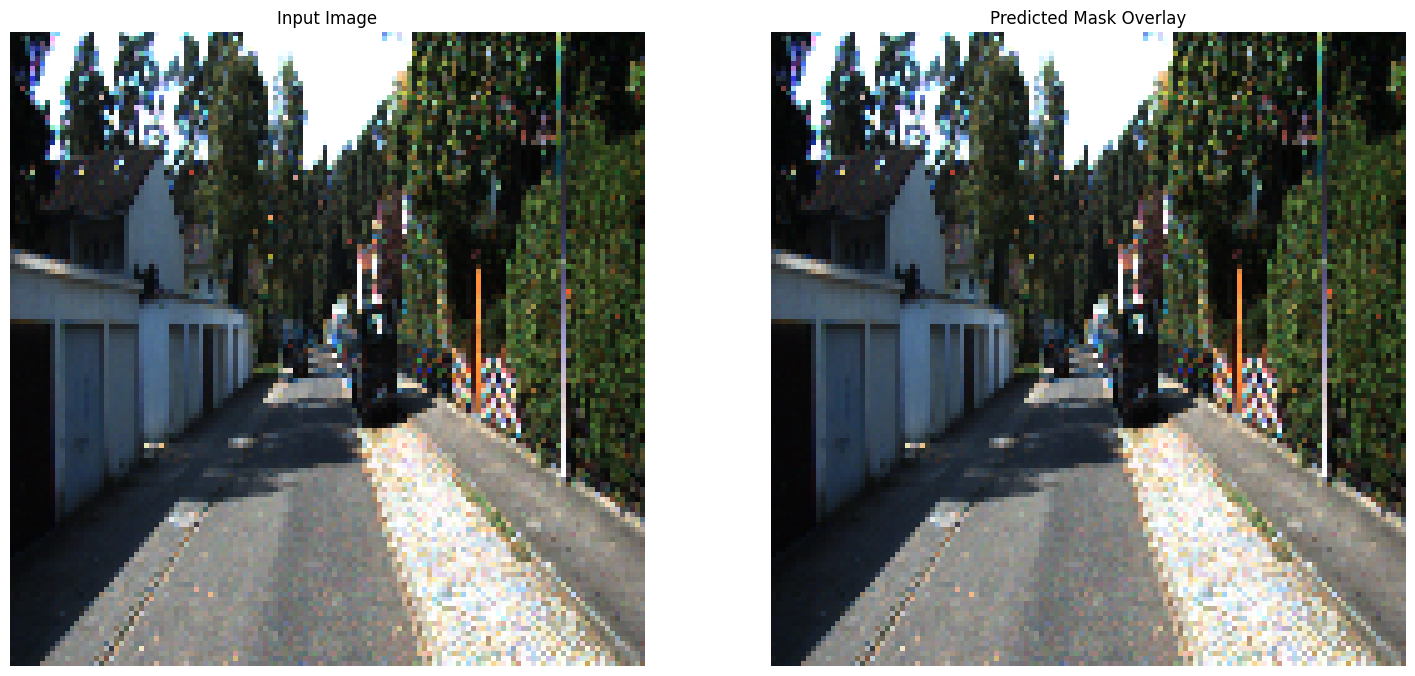

Processing image: 15
1/1 [==============================] - 0s 18ms/step


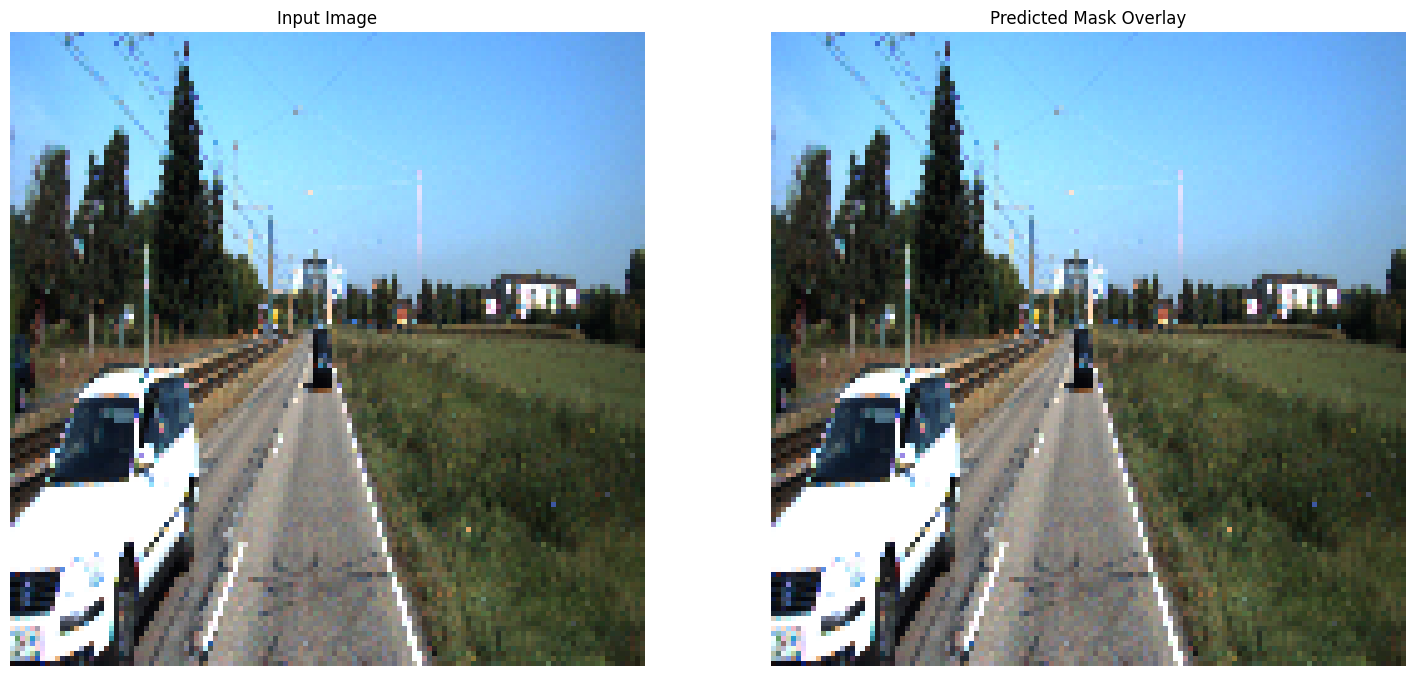

Processing image: 16
1/1 [==============================] - 0s 18ms/step


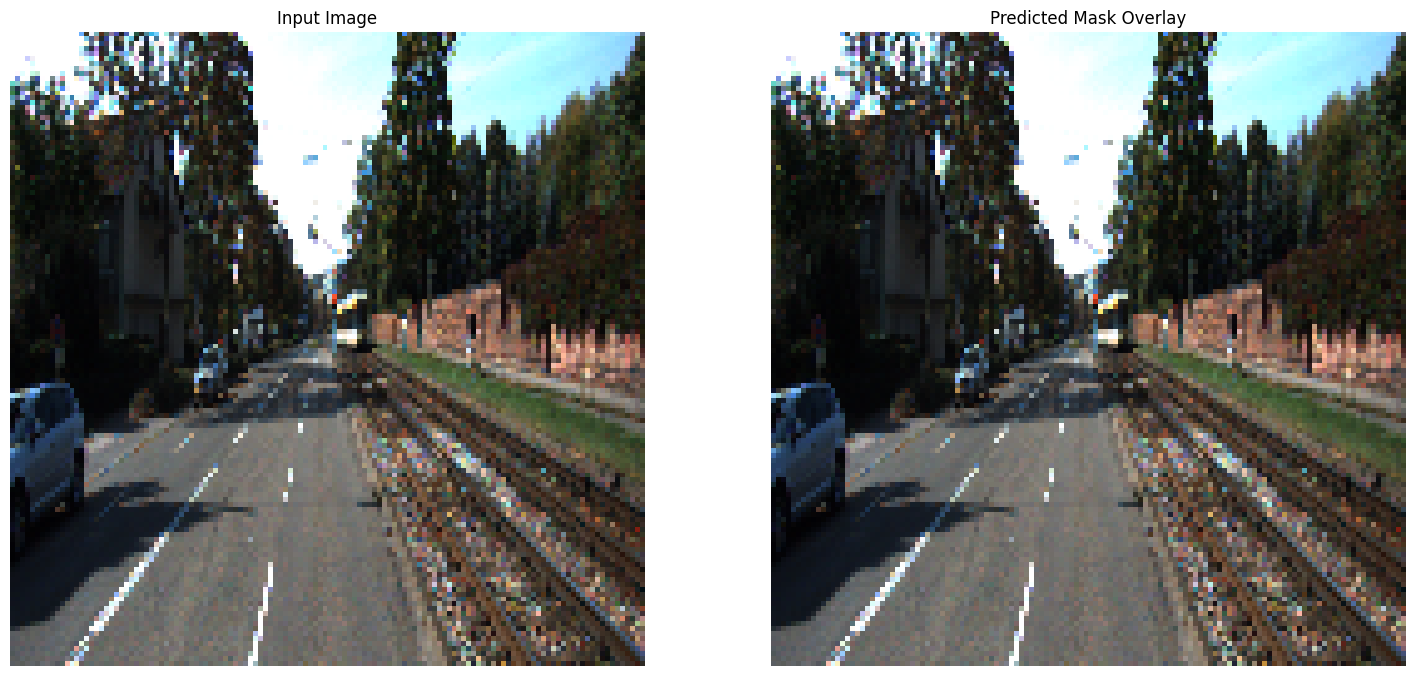

Processing image: 17
1/1 [==============================] - 0s 18ms/step


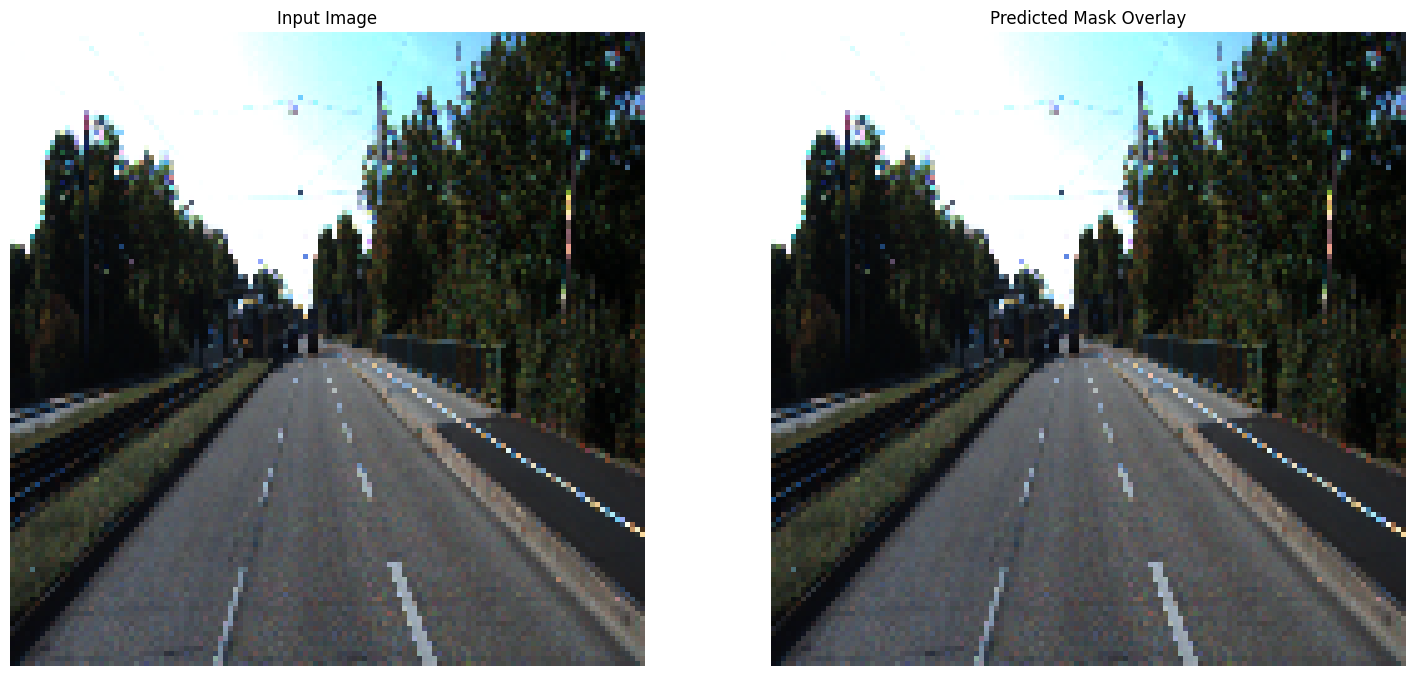

Processing image: 18
1/1 [==============================] - 0s 18ms/step


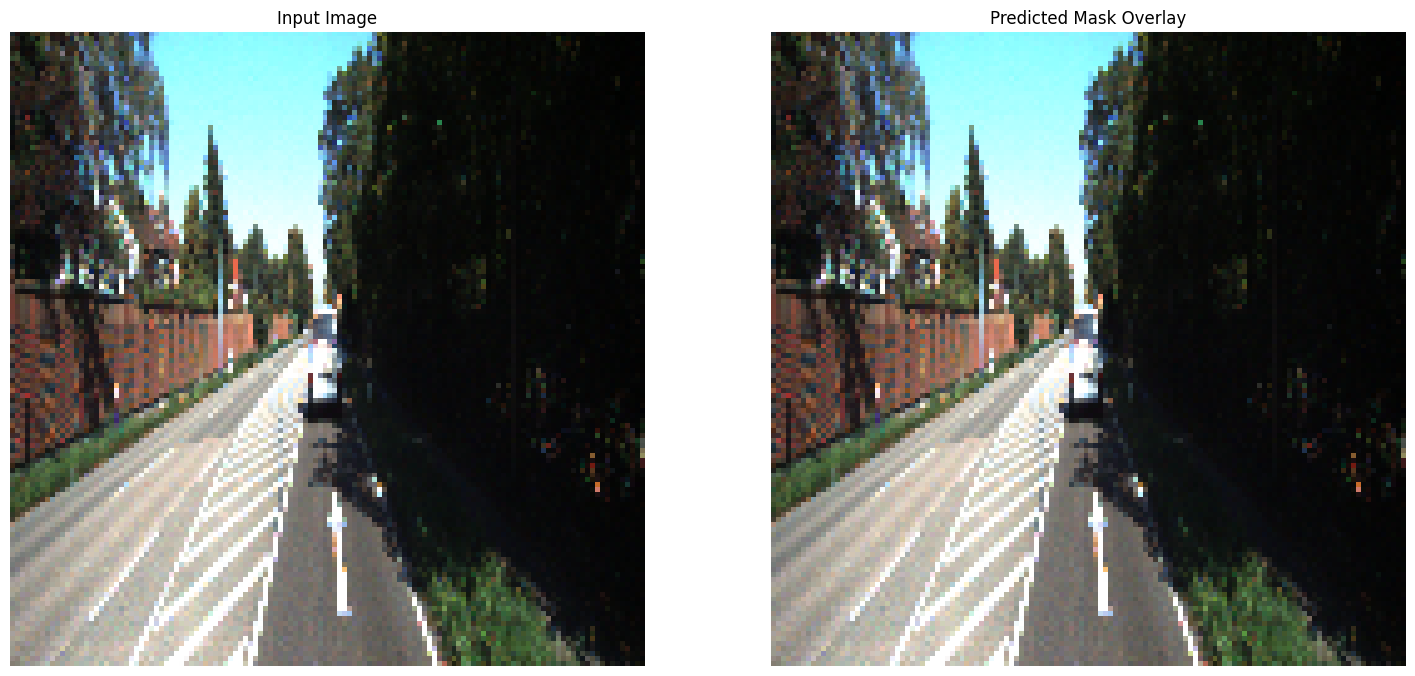

Processing image: 19
1/1 [==============================] - 0s 18ms/step


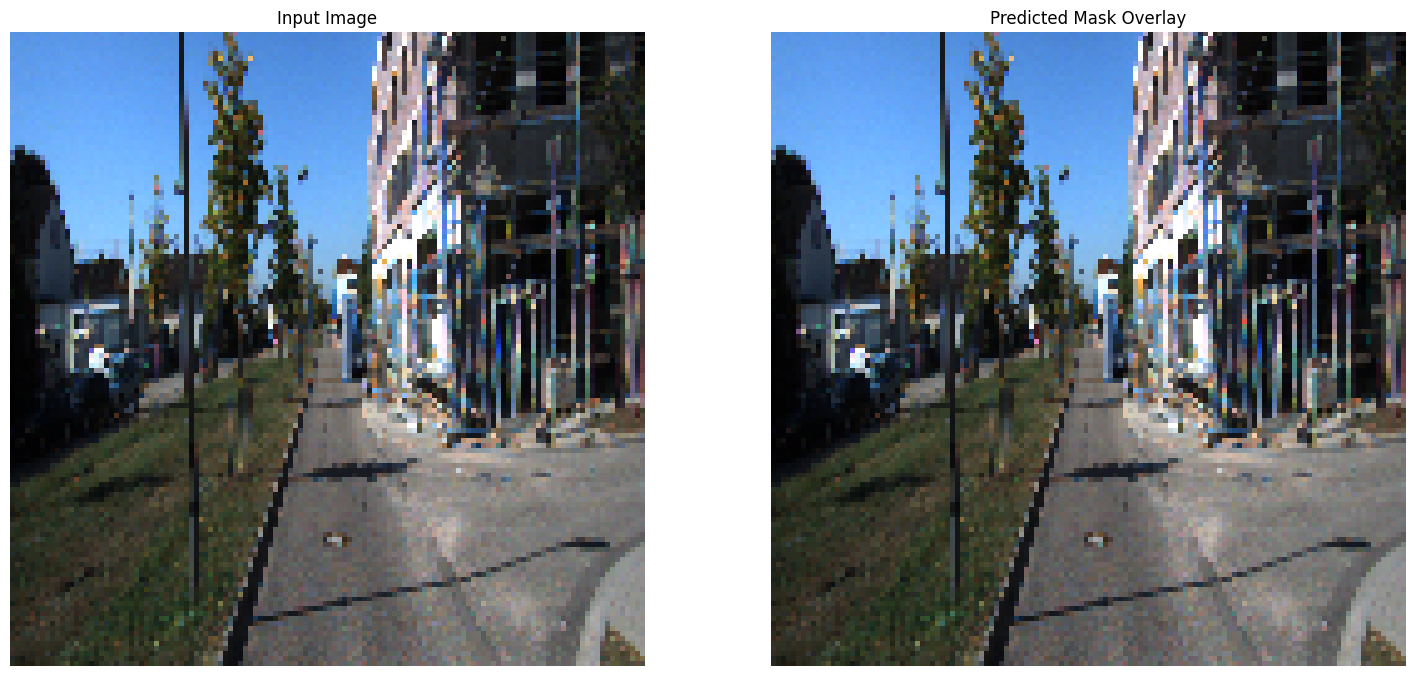

Processing image: 20
1/1 [==============================] - 0s 19ms/step


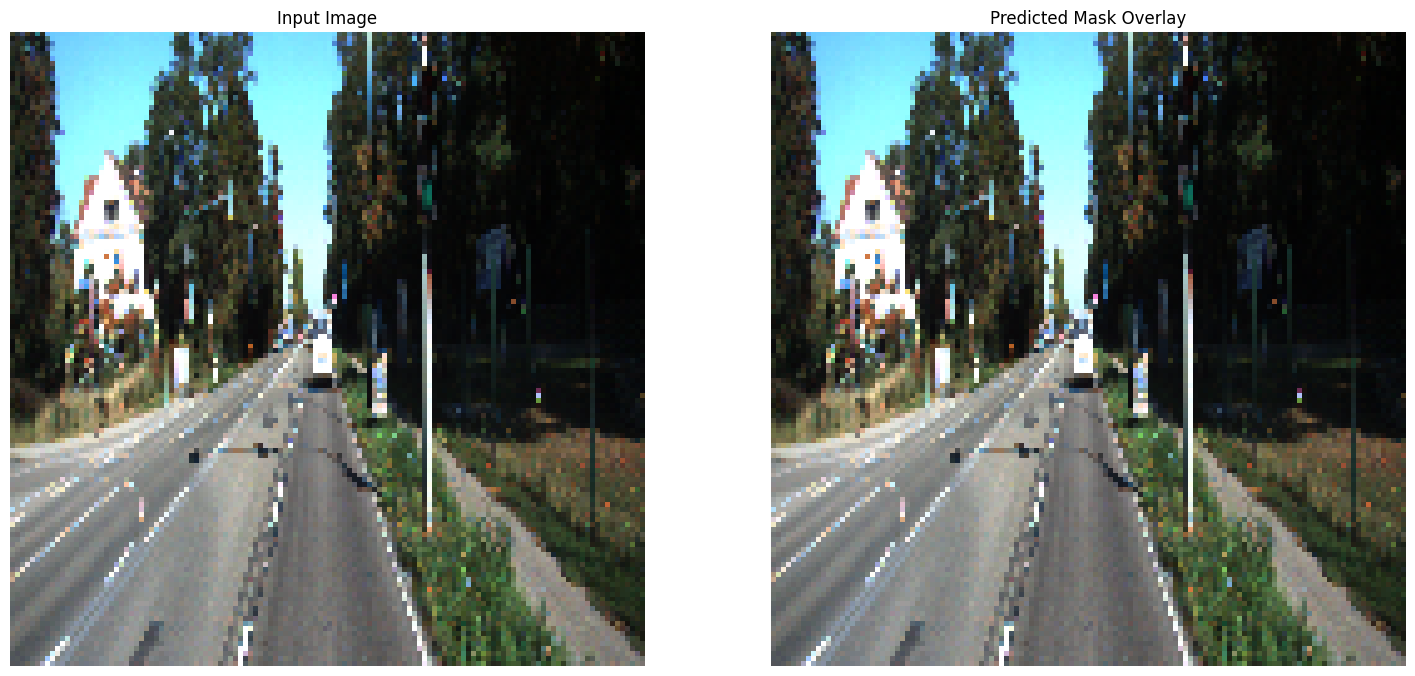

Processing image: 21
1/1 [==============================] - 0s 19ms/step


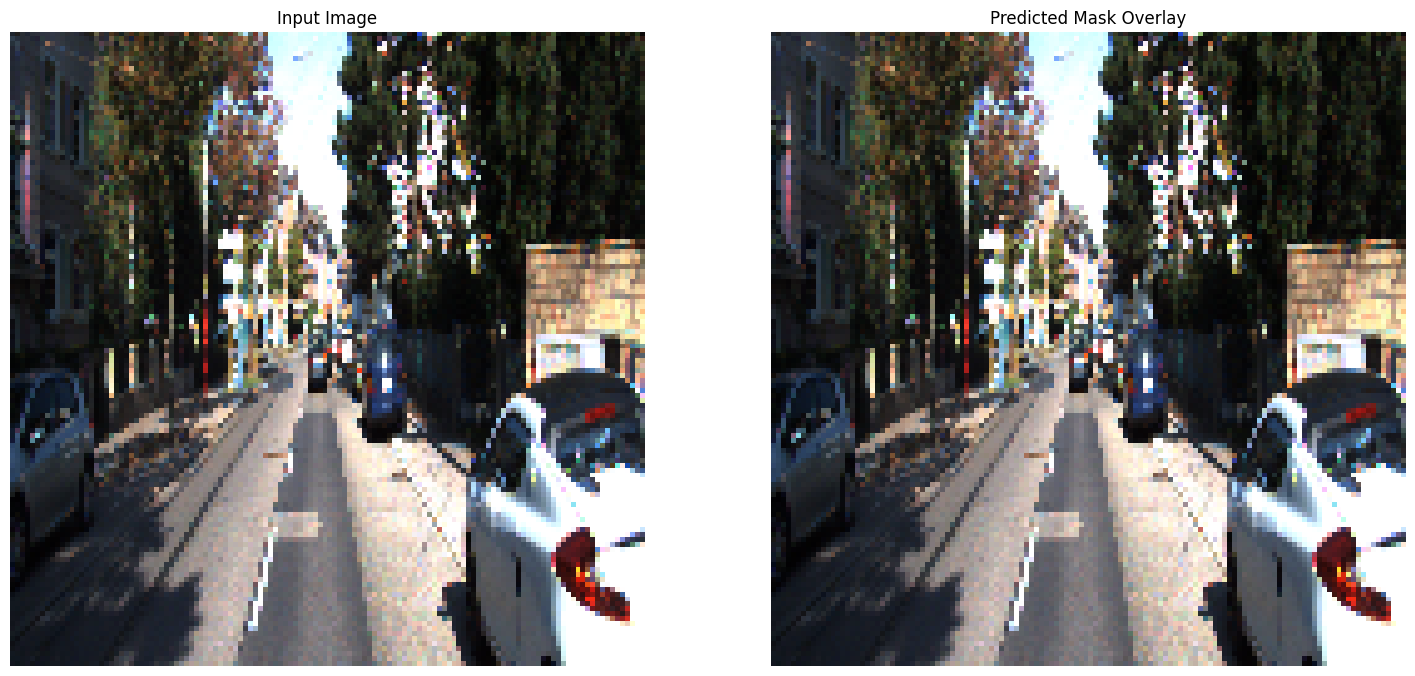

Processing image: 22
1/1 [==============================] - 0s 19ms/step


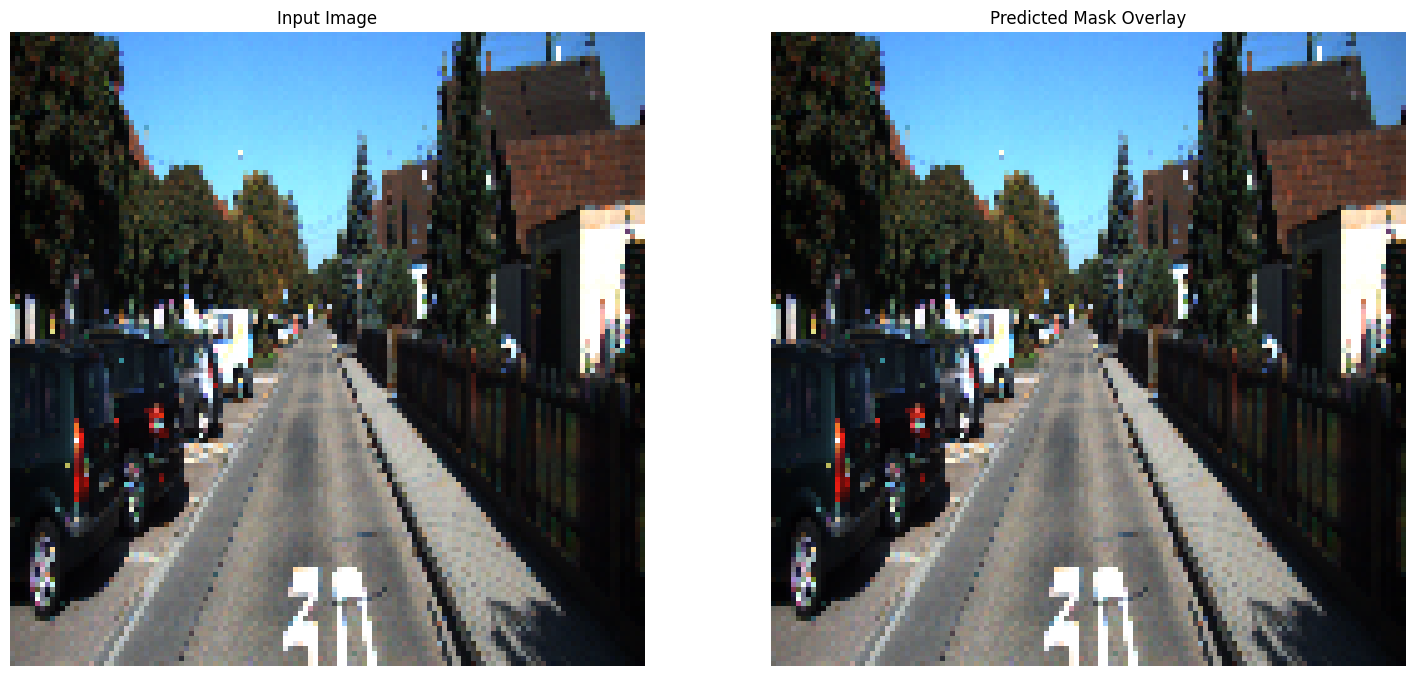

Processing image: 23
1/1 [==============================] - 0s 18ms/step


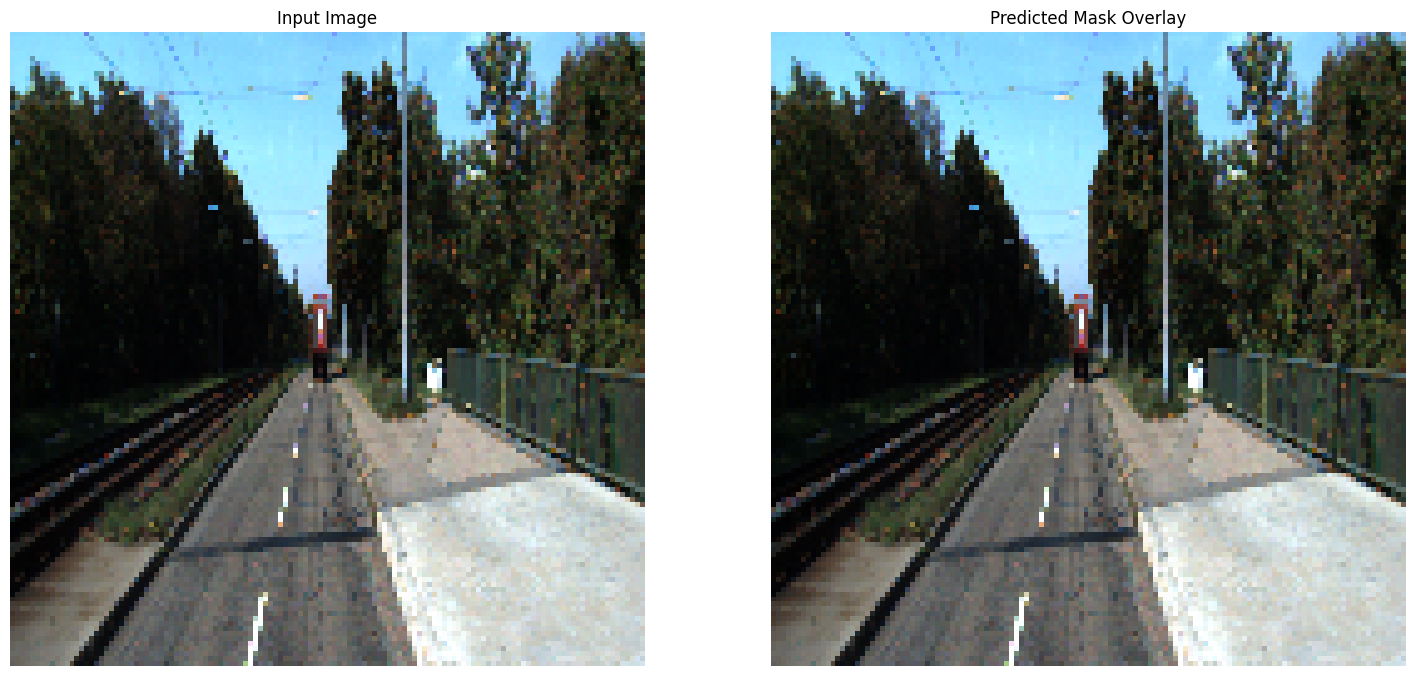

Processing image: 24
1/1 [==============================] - 0s 18ms/step


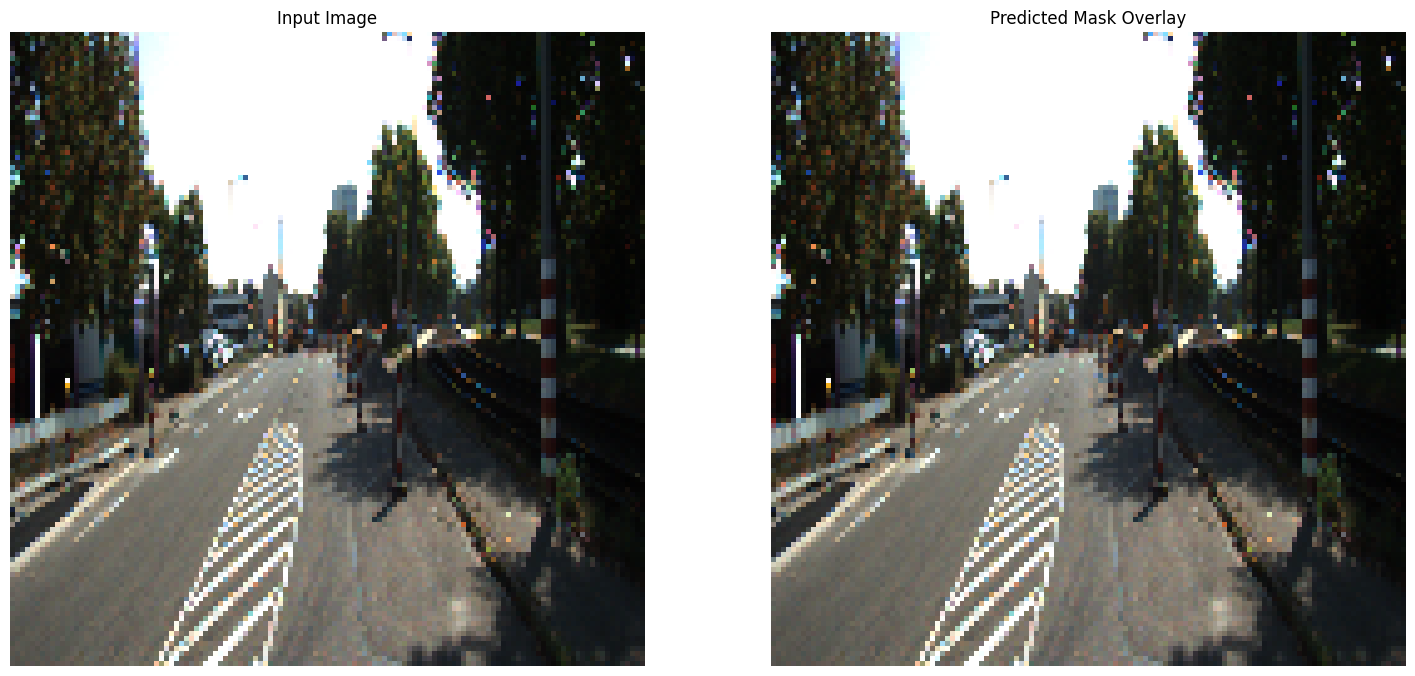

Processing image: 25
1/1 [==============================] - 0s 18ms/step


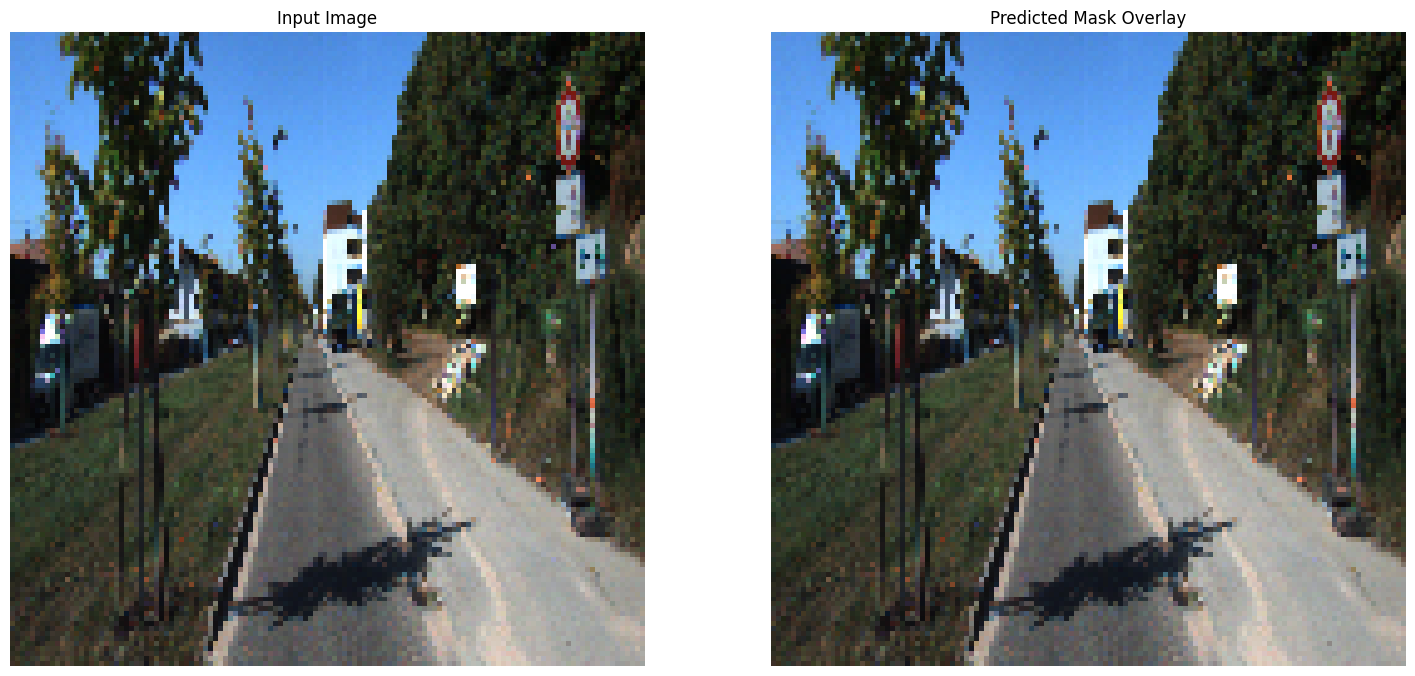

Processing image: 26
1/1 [==============================] - 0s 20ms/step


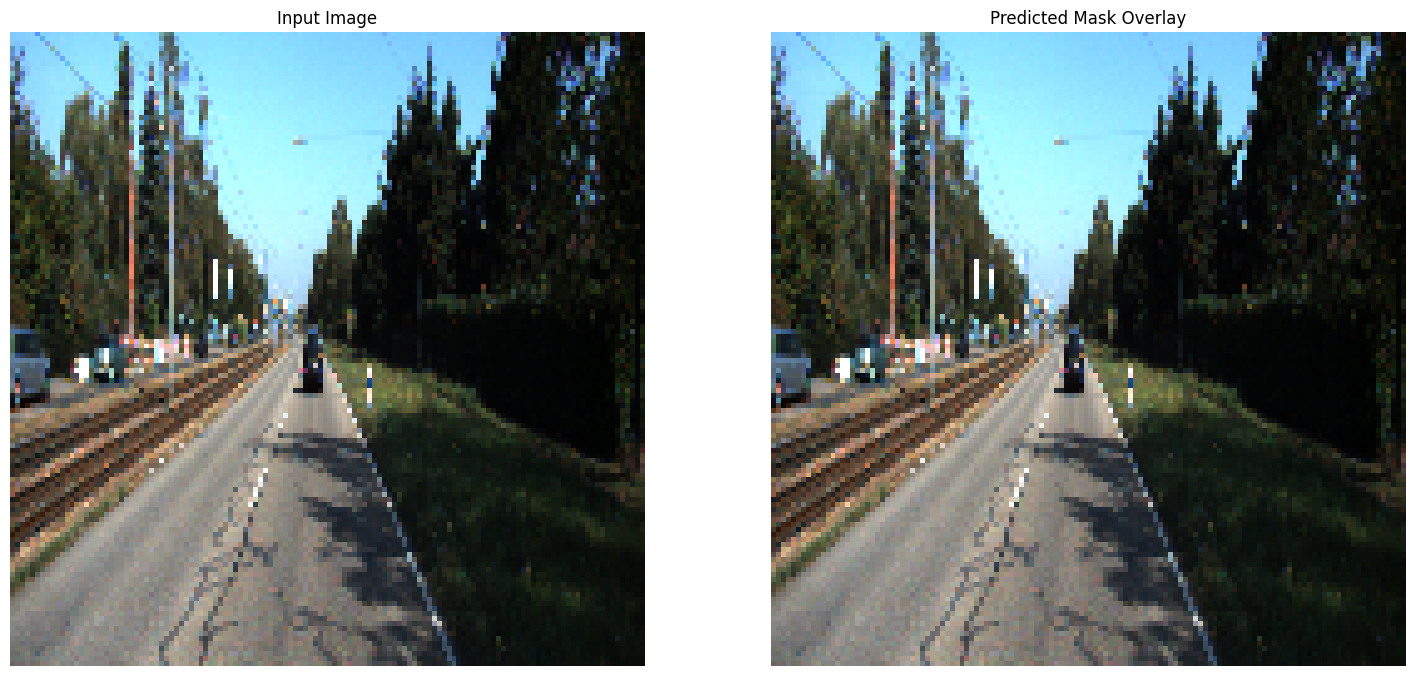

Processing image: 27
1/1 [==============================] - 0s 21ms/step


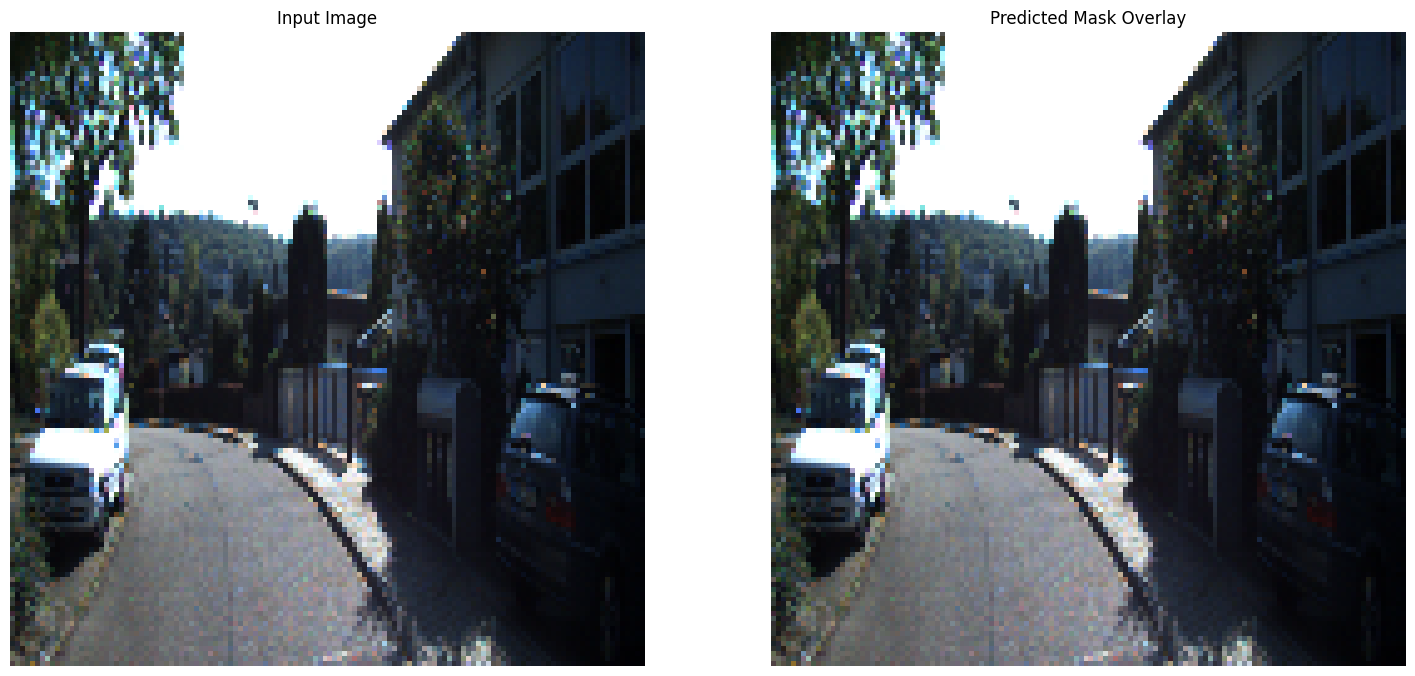

Processing image: 28
1/1 [==============================] - 0s 19ms/step


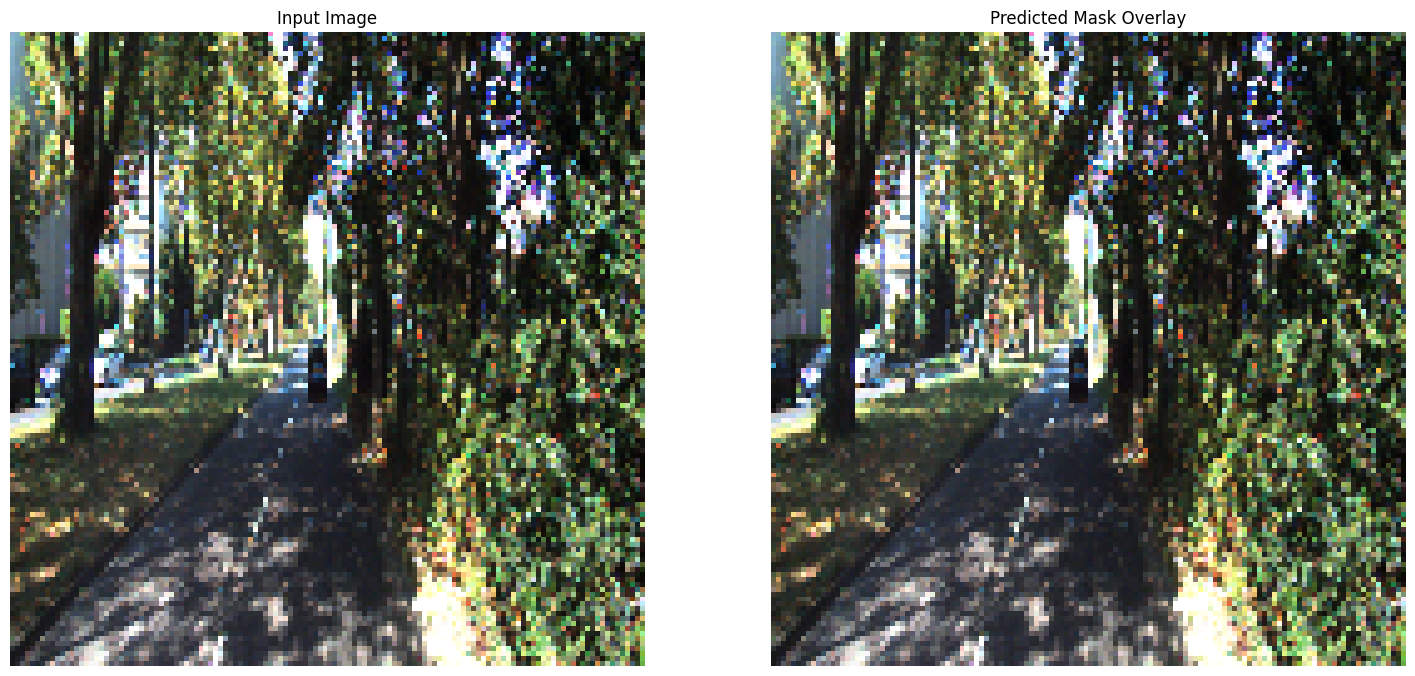

Processing image: 29
1/1 [==============================] - 0s 18ms/step


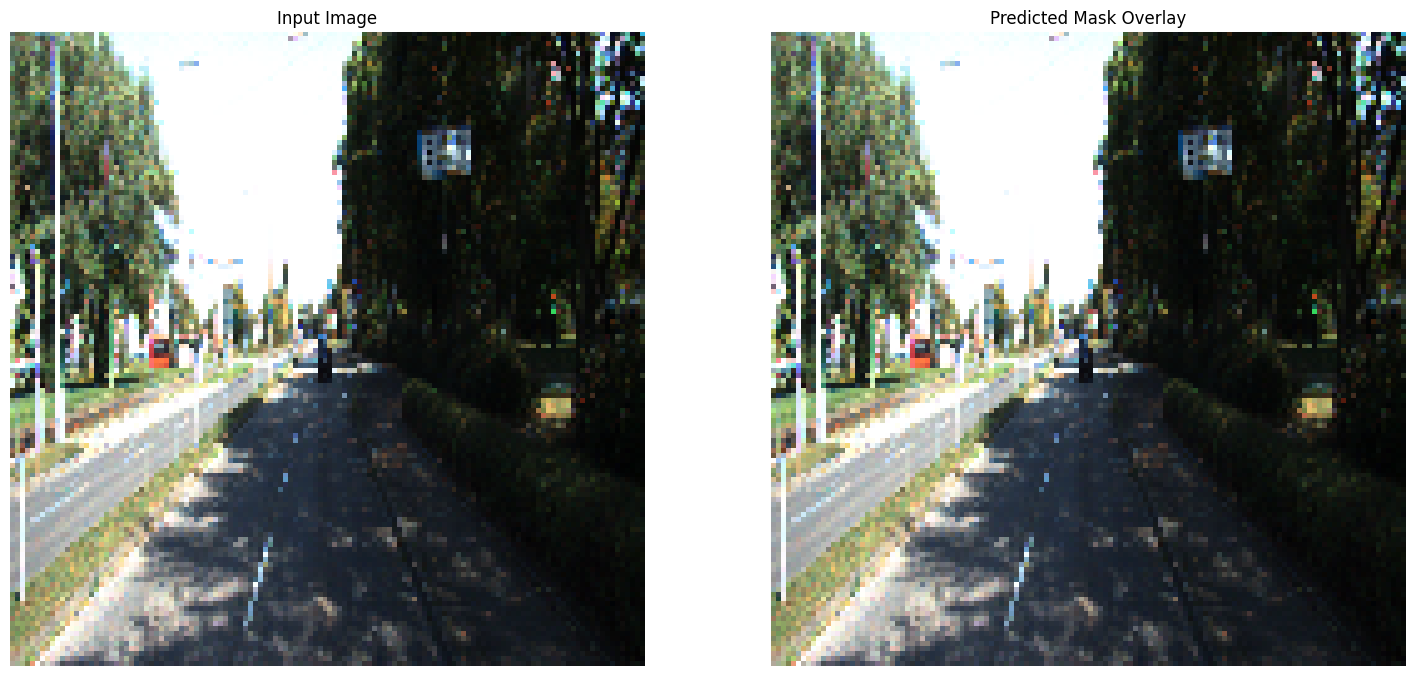

In [20]:
# Create a directory to store the output images
if not os.path.exists("outputs"):
    os.makedirs("outputs")

# Saving predictions for the test dataset
store_model_predictions(datasets['test'])


In [21]:
# Function to process and predict the mask for an individual image
def process_and_predict_mask(image):
    # Resize the image to the input size expected by the model
    resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Predict the binary mask using the trained model
    prediction_mask = model.predict(np.expand_dims(resized_image, axis=0))
    rounded_mask = np.round_(prediction_mask[0])
    
    # Constructing the mask image
    blank_channel = np.zeros_like(rounded_mask)
    red_mask = np.dstack((rounded_mask, blank_channel, blank_channel)) * 255
    red_mask = np.asarray(red_mask, np.uint8)
    
    # Overlay the mask on the original image
    overlayed_image = overlay_mask_on_image(red_mask, resized_image)
    resized_overlayed_image = cv2.resize(overlayed_image, (1280, 720))

    return resized_overlayed_image


In [22]:
# Make a new directory
os.mkdir("output_videos")


In [23]:
# Read and process a specific video file
video_filename = "challenge_video.mp4"
video_capture = cv2.VideoCapture(test_images_path + video_filename)
video_frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
video_frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Setting up the codec and creating a VideoWriter object for output
video_output_codec = cv2.VideoWriter_fourcc(*'mp4v')
video_fps = 60
processed_video_output = cv2.VideoWriter(f"videos/{video_filename}", video_output_codec, video_fps, (video_frame_width, video_frame_height))

# Processing the video, frame by frame
while video_capture.isOpened():
    frame_obtained, current_frame = video_capture.read()

    if frame_obtained:
        # Process each frame and write to the output video file
        processed_frame = process_and_predict_mask(current_frame)
        processed_video_output.write(processed_frame)
    else:
        break

# Release the video capture and video writer objects after processing
video_capture.release()
processed_video_output.release()


1/1 [==============================] - 0s 18ms/step


In [24]:
# Initialize VideoCapture for reading a specific video
selected_video = "harder_challenge_video.mp4"
video_reader = cv2.VideoCapture(test_images_path + selected_video)
width_of_video = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
height_of_video = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Setting the codec and initializing VideoWriter for saving the processed video
output_codec = cv2.VideoWriter_fourcc(*'mp4v')
video_frame_rate = 60
video_saver = cv2.VideoWriter(f"videos/{selected_video}", output_codec, video_frame_rate, (width_of_video, height_of_video))

# Loop to process each frame of the video
while video_reader.isOpened():
    frame_is_available, frame = video_reader.read()

    if frame_is_available:
        # Apply image processing to each frame and save it
        processed_frame = process_and_predict_mask(frame)
        video_saver.write(processed_frame)
    else:
        break

# Release the resources after processing the video
video_reader.release()
video_saver.release()


1/1 [==============================] - 0s 19ms/step
